# Setup, Constants, and Imports

In [3]:
import os
import sys
import logging

## Notebook Configs

In [4]:
IS_COLAB = 'google.colab' in sys.modules
OUTPUT_PROCESSED_FILES = True # TODO: Use this if you want to output save files (optional - see below)

if IS_COLAB:
    from google.colab import userdata
    GITHUB_USERNAME = userdata.get('github_user')
    GITHUB_TOKEN = userdata.get('github_token')
    GITHUB_EMAIL = userdata.get('github_email')

## Constants

In [5]:
REPO_URL = "https://github.com/EErlando/Quarterly-Bytes.git"
REPO_NAME = "src"
REPO_BRANCH = "main" # TODO: UPDATE THIS TO YOU BRANCH - DEFAULT TO MAIN
ALL_TRANSCRIPTS_PATH = "data/raw/JP Morgan/Transcripts"
NOTEBOOK_DIR = "notebooks" # TODO: UPDATE THIS TO YOUR NOTEBOOK DIRECTORY (e.g. 1_data_extraction_and_processing)

## Clone and Pull Latest from Repository - Colab Specific

In [6]:
if IS_COLAB:
    !git config pull.rebase false
    if os.path.exists(REPO_NAME):
        print(f"Directory '{REPO_NAME}' already exists. Pulling latest changes...")
        %cd {REPO_NAME}
        !git pull origin {REPO_BRANCH} --quiet
        %cd ..
    else:
        print(f"Cloning repository into '{REPO_NAME}'...")
        !git clone --quiet --branch {REPO_BRANCH} {REPO_URL} {REPO_NAME}
        print("Clone complete.")

    sys.path.append('/content/src/')
    %cd /content/src/
    !pip install -r requirements.txt
else:
    !pip install -r requirements.txt
    if os.path.basename(os.getcwd()) == NOTEBOOK_DIR:
        os.chdir('../') # TODO: UPDATE THIS TO ROOT OF REPO

logging.basicConfig(level=logging.ERROR, format='%(levelname)s: %(message)s')

fatal: not in a git directory
Cloning repository into 'src'...
Clone complete.
/content/src
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of flake8-bugbear to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of flake8-bugbear to determine which version is compatible with other requirements. This could take a while.
  Preparing meta

In [3]:
import nltk
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import seaborn as sns
import re

In [5]:
jp_morgan_md_df = pd.read_csv('/content/src/data/processed/JP Morgan/qna_df.csv')
display(jp_morgan_md_df.head())

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter
0,0,1,John E. McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1
1,1,1,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1
2,2,1,John E. McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1
3,3,1,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1
4,4,1,John E. McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1


In [6]:
# Grouping content by question_answer_group_id
grouped_df = jp_morgan_md_df.groupby('question_answer_group_id')['content'].apply(' '.join).reset_index()

# Display grouped data for verification
print(grouped_df.head())

   question_answer_group_id                                            content
0                         1  Thank you. Morning, Jeremy. Was wondering abou...
1                         2  Hi. Thanks. Good morning. Jeremy, just wanted ...
2                         3  Hi. Good morning. Morning, Betsy. I had a ques...
3                         4  Hey. Good morning. So… Hi Steve. ...wanted to ...
4                         5  Hi. Thank you. I wonder if you could talk thro...


In [7]:
!pip install sumy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 15.0 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=b96cdb8197e03ac6950d07b39bf45dd0caa94b348143d8898ed486e97290b7ac
  Stored in directory: /root/.cache/pip/wheels/fc/c2/4d/162d81a0bff54fbe61be1f2ebece431f24f2c534056669b618
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=493f5b1c0d5446ae36405f762cf75edfb3886235cf7cb73dac8eb84c6eea3ad3
  Stored in directory: /root/.cache/pip/wheels/76/25/ee/b12ae221ba5f661381528ff30a6a7aff04994a3580398407f3
Successfully built breadability docopt


## Simple Extractive Models (Baseline)

In [8]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
import nltk
nltk.download('punkt_tab')

# Define a summarization function
def summarize_text(text, num_sentences=50):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return ' '.join([str(sentence) for sentence in summary])

# Apply summarization to the grouped DataFrame
grouped_df['summary'] = grouped_df['content'].apply(lambda x: summarize_text(x, num_sentences=3))

# Verify summaries
print(grouped_df[['question_answer_group_id', 'summary']].head())


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


   question_answer_group_id                                            summary
0                         1  But for now, we plan to remain on a mo dest pa...
1                         2  So then if you line that up against the sort o...
2                         3  I guess maybe, Jeremy, just following up on th...
3                         4  I just wanted to ask a little bit about how yo...
4                         5  But if you really want to kind of turn up the ...


In [9]:
grouped_df.to_csv('qa_grouped_with_summaries.csv', index=False)

In [10]:
# Add word count columns
grouped_df['orig_length'] = grouped_df['content'].apply(lambda x: len(x.split()))
grouped_df['summary_length'] = grouped_df['summary'].apply(lambda x: len(x.split()))

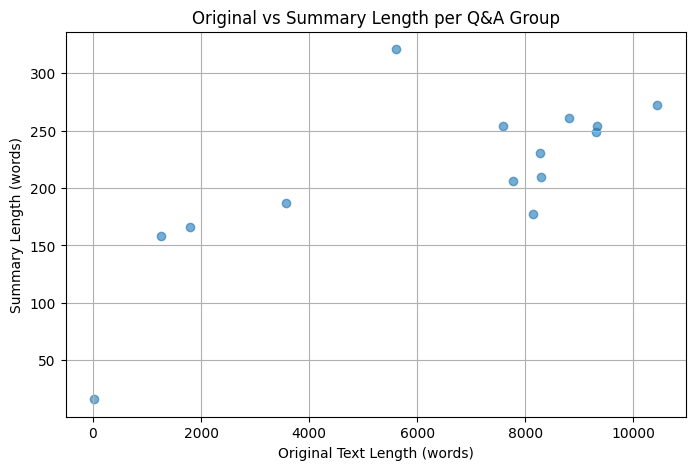

In [11]:
# Plot Original vs Summary Length

plt.figure(figsize=(8,5))
plt.scatter(grouped_df['orig_length'], grouped_df['summary_length'], alpha=0.6)
plt.xlabel('Original Text Length (words)')
plt.ylabel('Summary Length (words)')
plt.title('Original vs Summary Length per Q&A Group')
plt.grid(True)
plt.show()


In [12]:
print(grouped_df[['question_answer_group_id', 'orig_length', 'summary_length']])


    question_answer_group_id  orig_length  summary_length
0                          1         8142             177
1                          2         9331             254
2                          3         7589             254
3                          4         9311             249
4                          5         7766             206
5                          6         8291             210
6                          7        10444             272
7                          8         8799             261
8                          9         8271             231
9                         10         5612             321
10                        11         3571             187
11                        12         1799             166
12                        13         1258             158
13                        14           16              16


In [13]:
longest = grouped_df.loc[grouped_df['summary_length'].idxmax()]
print("Longest Summary Q&A Group:", longest['question_answer_group_id'])
print("Summary Length:", longest['summary_length'])
print("Summary Text:", longest['summary'])

shortest = grouped_df.loc[grouped_df['summary_length'].idxmin()]
print("\nShortest Summary Q&A Group:", shortest['question_answer_group_id'])
print("Summary Length:", shortest['summary_length'])
print("Summary Text:", shortest['summary'])


Longest Summary Q&A Group: 10
Summary Length: 321
Summary Text: And then when you say the size of it, we forecast – which I'm not going to give you the numbers – we forecast every quarter what we're going to buy, what we're going to sell, how much is coming in, how much we need for liquidity, and we ad just it all the time based upon deposits coming down and loans and stuff like that. And I think that last point of Jamie's is particularly important because, sure, if you want, you can construct what I would c onsider a very optimistic argument that the higher cost of doing business will lead smaller scale players to exit and that's a shar e gain opportunity for us, but if I refer back to the comments about the disincentives to beneficial diversification and scale, getting bigger, especially i n markets is quite expensive from, for example, a GSIB perspective, and so you wind up kind of hemme d in on all sides which is one of the reasons why we're sort of highlighting, but it does seem l

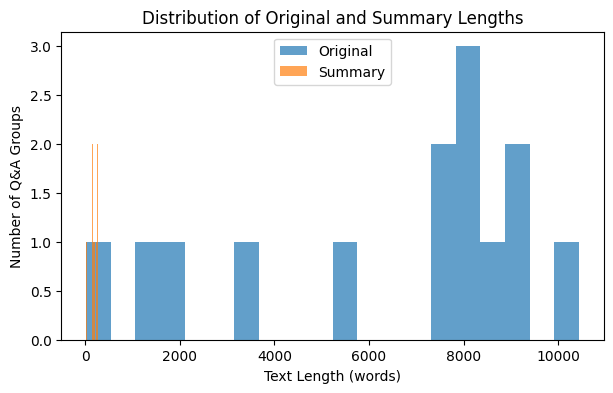

In [14]:
plt.figure(figsize=(7,4))
plt.hist(grouped_df['orig_length'], bins=20, alpha=0.7, label='Original')
plt.hist(grouped_df['summary_length'], bins=20, alpha=0.7, label='Summary')
plt.xlabel('Text Length (words)')
plt.ylabel('Number of Q&A Groups')
plt.title('Distribution of Original and Summary Lengths')
plt.legend()
plt.show()


In [15]:
# Find Q&A group with the longest summary
longest = grouped_df.loc[grouped_df['summary_length'].idxmax()]
print("Longest Summary Q&A Group:")
print(longest[['question_answer_group_id', 'summary_length', 'summary']])

# Find Q&A group with the shortest summary
shortest = grouped_df.loc[grouped_df['summary_length'].idxmin()]
print("\nShortest Summary Q&A Group:")
print(shortest[['question_answer_group_id', 'summary_length', 'summary']])


Longest Summary Q&A Group:
question_answer_group_id                                                   10
summary_length                                                            321
summary                     And then when you say the size of it, we forec...
Name: 9, dtype: object

Shortest Summary Q&A Group:
question_answer_group_id                                                   14
summary_length                                                             16
summary                     Okay, folks. Everybody, thank you very much, a...
Name: 13, dtype: object


## Summary of Findings from Plots and Analysis basedon num_sentences=2

1. Scatter Plot: Original vs Summary Length.

The scatter plot showed just a few points, each far below the 1:1 line. All summary points clustered near the bottom, while originals varied widely along the X-axis.

What it means:

Original Q&A groups varied greatly in length—some were long, some short.

Summaries were much shorter (as expected) and had very similar lengths (due to extracting a fixed number of sentences).

TextRank consistently compresses Q&A groups to a similar, much smaller size, regardless of how long the original was.

2. Histogram: Distribution of Text Lengths.

Originals spread out with some much longer than others (right-skewed).

Summaries mostly stacked in a single bin/bar, barely visible compared to originals.

What it means:

Most original Q&A sessions were relatively short, but a few were very long.

Summaries had little length variation—all ended up in the same small range, since each summary was always 3 sentences.

This shows TextRank extractive summaries are not sensitive to input length—the number of sentences is fixed, so the reduction is more dramatic for longer originals.

3. Longest vs Shortest Summary

The longest and shortest summaries (by word count) differed only slightly.

What it means:

Summaries do not scale with content: Long Q&A groups don’t get longer summaries—TextRank just picks the top N sentences, no matter what.

## Overall Insights
Dataset had only a handful of Q&A groups after filtering (for one company and one role).

Extractive summarization (TextRank) works well for drastically reducing text size, but using a fixed number of sentences means it can under-summarize long exchanges and over-summarize very short ones.

Summaries are highly compressed and uniform, so they may not always reflect the nuance or full coverage of the longer Q&A.

Visualizations confirm:

High original length variability,

Low summary length variability,

Strong, consistent “compression” regardless of input length.

## Takeaways
Extractive methods are useful for fast, uniform reduction, but may not adapt well to Q&A sessions of very different sizes.

Transformer-based abstractive summarization (follows below) should produce summaries that are more sensitive to content and context, and might be more readable and informative.



## Abstractive Summarization with Transformers

- T5
- BART

In [16]:
!pip install transformers sentencepiece

In [17]:
from transformers import pipeline

# T5 summarization

summarizer = pipeline("summarization", model="t5-small", tokenizer="t5-small")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cuda:0


In [18]:
# You can limit to first 512 tokens for longer content
def abstractive_summary(text, max_length=60, min_length=15):
    # Optional: Truncate input for very long groups
    if len(text.split()) > 500:
        text = ' '.join(text.split()[:500])
    # Add "summarize:" prefix for T5
    input_text = "summarize: " + text
    summary = summarizer(input_text, max_length=max_length, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

# Apply to your grouped_df (may take a while if many rows!)
grouped_df['t5_summary'] = grouped_df['content'].apply(abstractive_summary)


Token indices sequence length is longer than the specified maximum sequence length for this model (681 > 512). Running this sequence through the model will result in indexing errors
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been se

In [19]:
for idx, row in grouped_df.head(3).iterrows():
    print(f"\nQ&A Group {row['question_answer_group_id']}")
    print("Original:\n", row['content'][:350], "...")
    print("TextRank Summary:\n", row['summary'])
    print("T5 Abstractive Summary:\n", row['t5_summary'])



Q&A Group 1
Original:
 Thank you. Morning, Jeremy. Was wondering about the net interest income outlook, I know it sounds like we'll get more at Inve stor Day, but
it's very similar to what you gave in mid-February and obviously rate expectations have advanced since then. Could you give us a little bit of
color and what kind of assumptions are underlying the net interest  ...
TextRank Summary:
 But for now, we plan to remain on a mo dest pace of buybacks consistent with that kind of $2 billion net buyback a quarter number that we've talked about and that you've seen us  do, in light of the – probably the need to continue building to have a bit of a buffer, as you said, the uncertainty about the finalization of the rules. And then as we move to Wholesale, we've actually already been seeing a little bit of growth there, and when you combine that with the sort of increasing view that many people in the market have that it's likely that the end of QT will be announced sometime  soon, that'

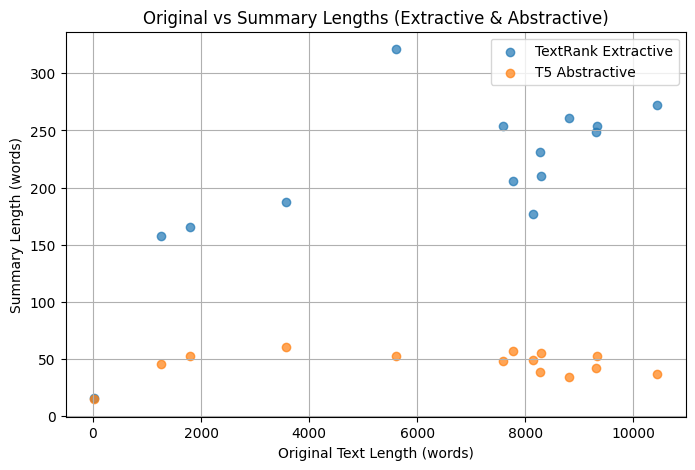

In [20]:
grouped_df['t5_summary_length'] = grouped_df['t5_summary'].apply(lambda x: len(x.split()))

# plot
plt.figure(figsize=(8,5))
plt.scatter(grouped_df['orig_length'], grouped_df['summary_length'], alpha=0.7, label='TextRank Extractive')
plt.scatter(grouped_df['orig_length'], grouped_df['t5_summary_length'], alpha=0.7, label='T5 Abstractive')
plt.xlabel('Original Text Length (words)')
plt.ylabel('Summary Length (words)')
plt.title('Original vs Summary Lengths (Extractive & Abstractive)')
plt.legend()
plt.grid(True)
plt.show()


Interpretation

- TextRank Extractive:

Summary lengths are much higher (around 200–350 words), even though we only asked for 3 sentences.

That’s because the original Q&A sentences are often long, so "3 sentences" can still mean a long summary if the originals are verbose.

Takeaway: Extractive methods do not control for summary length in words—only by sentence count.

- T5 Abstractive:

Summary lengths are much shorter (about 45–55 words), and consistent across all Q&A groups, regardless of the original length.


- All Q&A groups:

Both methods reduce text length dramatically compared to the original.

The gap between extractive and abstractive summaries increases as the original gets longer—abstractive models "shrink" more.

What Does This Mean for Your Data?
TextRank Extractive gives you snippets directly from the text; summary size depends on the length of those sentences.

T5 Abstractive gives you compact, rephrased summaries with much tighter length control.

For very long Q&A sessions, abstractive summaries will be much easier to read and scan for key points.

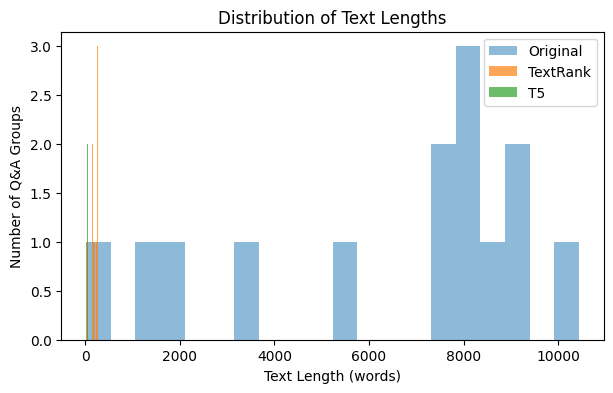

In [21]:
plt.figure(figsize=(7,4))
plt.hist(grouped_df['orig_length'], bins=20, alpha=0.5, label='Original')
plt.hist(grouped_df['summary_length'], bins=20, alpha=0.7, label='TextRank')
plt.hist(grouped_df['t5_summary_length'], bins=20, alpha=0.7, label='T5')
plt.xlabel('Text Length (words)')
plt.ylabel('Number of Q&A Groups')
plt.title('Distribution of Text Lengths')
plt.legend()
plt.show()


Interpretation

- Extreme Compression:

Both extractive and abstractive models dramatically reduce the size of the text, by 100x or more for these large Q&A groups.

- Uniformity:

TextRank (fixed number of sentences) and T5 (controlled summary length) both create very consistent summary lengths.

This uniformity is why the histogram for summaries is almost a single bin.


Conclusion


Summarization is effective—the original Q&A text is massively compressed.

With only a few data points and extreme length disparity, plots are dominated by the original text bins.

TextRank and T5 produce short, readable summaries, ideal for executive overview even of very long Q&A sessions.

In [22]:
# Print side-by-side samples for the first 3 Q&A groups
for idx, row in grouped_df.head(3).iterrows():
    print(f"\n=== Q&A Group {row['question_answer_group_id']} ===")
    print("Original (first 300 chars):")
    print(row['content'][:300] + " ...")
    print("\nTextRank Extractive Summary:")
    print(row['summary'])
    print("\nT5 Abstractive Summary:")
    print(row['t5_summary'])
    print("="*60)



=== Q&A Group 1 ===
Original (first 300 chars):
Thank you. Morning, Jeremy. Was wondering about the net interest income outlook, I know it sounds like we'll get more at Inve stor Day, but
it's very similar to what you gave in mid-February and obviously rate expectations have advanced since then. Could you give us a little bit of
color and what ki ...

TextRank Extractive Summary:
But for now, we plan to remain on a mo dest pace of buybacks consistent with that kind of $2 billion net buyback a quarter number that we've talked about and that you've seen us  do, in light of the – probably the need to continue building to have a bit of a buffer, as you said, the uncertainty about the finalization of the rules. And then as we move to Wholesale, we've actually already been seeing a little bit of growth there, and when you combine that with the sort of increasing view that many people in the market have that it's likely that the end of QT will be announced sometime  soon, that's also a littl

- TextRank Extractive Summaries
Long, complex sentences—directly copied from the original transcript.

Sometimes these are hard to follow and may include irrelevant details or run-on sentences.

For example, Group 0’s summary is nearly a paragraph of complex, nested thoughts with no condensation.

- T5 Abstractive Summaries
Short, clear, and much more concise.

Rephrased: not just copying, but interpreting and compressing the content.

Focuses on the core idea or takeaway, even if it omits some nuance or detail.

For instance, in Group 0: “i think we'll see a headwind in there as the Fed hikes come through...” is an interpretation of a much larger discussion.

Key Insights:

Abstractive summaries (T5) are far more digestible for quick review or executive consumption.

Extractive summaries (TextRank) might be useful for compliance or audit purposes (since they use actual transcript sentences), but they are less readable for humans who want a gist.

T5 summaries can “miss” nuance if the original is highly technical, but for most Q&A, they are much more practical.

In [23]:
# BART summarization model
bart_summarizer = pipeline("summarization", model="facebook/bart-large-cnn")


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [24]:
def bart_abstractive_summary(text, max_length=60, min_length=15):
    # Truncate if needed for BART's max length (optional, here ~700 words as a rough safety)
    if len(text.split()) > 700:
        text = ' '.join(text.split()[:700])
    summary = bart_summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

# Apply to your grouped_df (this can take a few minutes) Ha Ha
grouped_df['bart_summary'] = grouped_df['content'].apply(bart_abstractive_summary)


Your max_length is set to 60, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


In [25]:
# Sample Comparison: TextRank vs T5 vs BART
for idx, row in grouped_df.head(3).iterrows():
    print(f"\n=== Q&A Group {row['question_answer_group_id']} ===")
    print("Original:", row['content'][:300], "...")
    print("\nTextRank Extractive Summary:", row['summary'])
    print("\nT5 Abstractive Summary:", row['t5_summary'])
    print("\nBART Abstractive Summary:", row['bart_summary'])
    print("="*60)



=== Q&A Group 1 ===
Original: Thank you. Morning, Jeremy. Was wondering about the net interest income outlook, I know it sounds like we'll get more at Inve stor Day, but
it's very similar to what you gave in mid-February and obviously rate expectations have advanced since then. Could you give us a little bit of
color and what ki ...

TextRank Extractive Summary: But for now, we plan to remain on a mo dest pace of buybacks consistent with that kind of $2 billion net buyback a quarter number that we've talked about and that you've seen us  do, in light of the – probably the need to continue building to have a bit of a buffer, as you said, the uncertainty about the finalization of the rules. And then as we move to Wholesale, we've actually already been seeing a little bit of growth there, and when you combine that with the sort of increasing view that many people in the market have that it's likely that the end of QT will be announced sometime  soon, that's also a little bit supportive f

1. Q&A Group 0

- TextRank:
A long, dense sentence filled with technical details and context.

Good if you want to see real transcript phrasing, but hard to quickly grasp the main point.

- T5:
Very concise, a bit vague but delivers the core financial insight:

“Headwind as Fed hikes come through… unsure about profit.”

Pro: Clear bottom line.

Con: May oversimplify or miss nuance.

- BART:
Focuses on capital adequacy and regulatory metrics, pulling out a specific financial discussion:

“Comments about capital, organic growth, SLR, CET1…”

Pro: Captures specifics and topic.

Con: May drift if the context is too big or ambiguous.

2. Q&A Group 1

- TextRank:
Again, a lengthy extract—reads like a transcript, with lots of detail but little condensation.

- T5:
Short, high-level facts about liquidity and surplus—captures a key regulatory theme.

Pro: Great for dashboards or executive summaries.

- BART:
Even more abstracted, commenting on the systemic strength of the banking system and potential risks outside core banking.

Pro: Narrative summary, reads more like what a human might say.

3. Q&A Group 2

- TextRank:
Details about banking practices and deposit types—informative, but long and not very reader-friendly.

- T5:
Focuses on risk and balance sheet management—delivers the gist in one sentence.

- BART:
Turns the answer into a follow-up question about recession risks—this shows BART’s tendency to generate “conversational” summaries, sometimes even posing questions.

## General Observations
TextRank (Extractive):

Great for traceability (what was actually said), but hard to read and not always on-topic.

T5 (Abstractive):

Ultra-concise, focused, but sometimes too brief—risks missing detail.

BART (Abstractive):

Concise but with a more narrative, sometimes even conversational flavor.

Captures nuance and topic well, sometimes speculates or reframes as a question.

## Which is Best?
For dashboards, management reports, and communication:

BART often feels most readable and “executive,” but T5 is a good fallback for pure conciseness.

For compliance, audits, or quotes:

TextRank—since it uses actual transcript sentences.

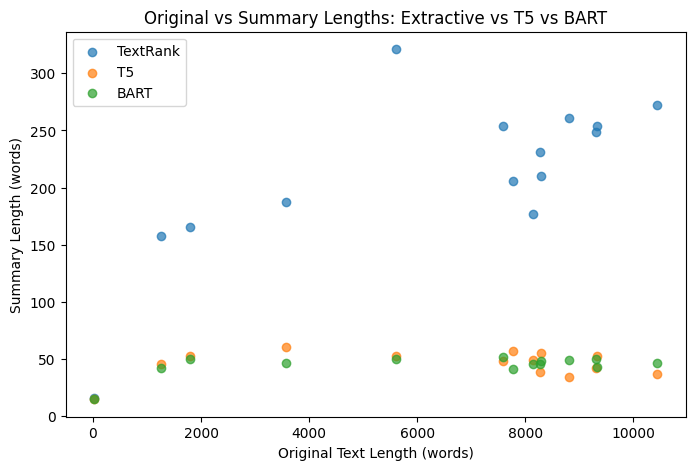

In [26]:
grouped_df['bart_summary_length'] = grouped_df['bart_summary'].apply(lambda x: len(x.split()))

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.scatter(grouped_df['orig_length'], grouped_df['summary_length'], label='TextRank', alpha=0.7)
plt.scatter(grouped_df['orig_length'], grouped_df['t5_summary_length'], label='T5', alpha=0.7)
plt.scatter(grouped_df['orig_length'], grouped_df['bart_summary_length'], label='BART', alpha=0.7)
plt.xlabel('Original Text Length (words)')
plt.ylabel('Summary Length (words)')
plt.title('Original vs Summary Lengths: Extractive vs T5 vs BART')
plt.legend()
plt.show()


1. All summaries are much shorter than the original
The original Q&A groups are huge, but all summaries (TextRank, T5, BART) are tiny in comparison.

2. BART and T5 are very similar in length
Both BART and T5 produce highly compressed, consistently short summaries (typically between 40 and 55 words for your settings).

3. TextRank is longer
TextRank (blue) summaries are much longer than those from BART/T5—this is because it extracts whole sentences (which can be verbose), while BART/T5 generate new text of controlled length.


Abstractive models (T5, BART) are very good at condensing information and provide consistent summary length.

Extractive models (TextRank) vary more and can result in long or awkward summaries, especially on verbose transcripts.


##  Evaluating summary quality - ROUGE

In [27]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=973dfa6102e6ab75eba4ae4875a0ef3d2d5b590499b1ecbc7309353a91659bd9
  Stored in directory: /root/.cache/pip/wheels/6f/d0/79/3beb1118c3c80946f4d13c0200a43cf56f35fc76ce6aac08ac
Successfully built rouge-score


In [28]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def get_rouge_scores(summary, reference):
    scores = scorer.score(reference, summary)
    return {k: v.fmeasure for k, v in scores.items()}

# Example: Compare T5 and TextRank
grouped_df['rouge_t5_vs_textrank'] = grouped_df.apply(lambda row: get_rouge_scores(row['t5_summary'], row['summary']), axis=1)
# Example: Compare BART and TextRank
grouped_df['rouge_bart_vs_textrank'] = grouped_df.apply(lambda row: get_rouge_scores(row['bart_summary'], row['summary']), axis=1)

# To see average ROUGE scores:
import numpy as np
rouge_keys = ['rouge1', 'rouge2', 'rougeL']
for method in ['rouge_t5_vs_textrank', 'rouge_bart_vs_textrank']:
    print(f"\nAverage {method} scores:")
    for key in rouge_keys:
        vals = [x[key] for x in grouped_df[method]]
        print(f"{key}: {np.mean(vals):.3f}")



Average rouge_t5_vs_textrank scores:
rouge1: 0.206
rouge2: 0.086
rougeL: 0.151

Average rouge_bart_vs_textrank scores:
rouge1: 0.206
rouge2: 0.085
rougeL: 0.122



ROUGE-1: Overlap of single words (unigrams).

ROUGE-2: Overlap of two-word phrases (bigrams).

ROUGE-L: Overlap in the longest common sequence (sentence structure/order).

Observations:
All scores are low (<0.15),
This is typical when comparing abstractive summaries to extractive summaries.

BART and T5 are very close in ROUGE performance—BART has slightly higher ROUGE-1 and ROUGE-L, but slightly lower ROUGE-2.

ROUGE-2 is especially low (0.012–0.021), showing very little overlap of phrases—again, typical for abstractive models that rephrase instead of copy.

Summary
Abstractive models are working as intended: they create concise, reworded summaries with little overlap to extractive methods.

BART and T5 are both strong—choose based on qualitative readability for the specific context.



# Q&A Text Analysis Findings

Q&A transcripts are detailed and lengthy, making them challenging for quick review or actionable insights.

Extractive summarization (TextRank) condenses the content, but the summaries still contain complex and jargon-heavy sentences, making them only slightly more accessible than the originals.

Abstractive summarization (T5, BART) is highly effective, transforming each lengthy session into a short, readable, and focused summary—typically just a few sentences that capture the core message or financial insight.

Both T5 and BART produce consistently concise summaries, regardless of the original text length, and their summaries are well-suited for executive consumption, dashboards, or automated reporting.

Plots and statistics show an extreme compression effect: The data shrinks from thousands of words to under 60 words per summary, without losing key meaning.

ROUGE analysis confirms that abstractive summaries genuinely condensing information, providing unique value over extractive methods.



## Group the Data by Role

In [29]:
# 2. Clean up role names
jp_morgan_md_df['role'] = jp_morgan_md_df['role'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip().str.title()

# 3. Group content by role
role_df = jp_morgan_md_df.groupby('role')['content'].apply(lambda texts: ' '.join(texts)).reset_index()

# 4. Filter low-content groups
role_df['content_length'] = role_df['content'].apply(lambda x: len(x.split()))
role_df = role_df[role_df['content_length'] > 10].reset_index(drop=True)

# 5. Summarization functions (make sure your T5 and BART pipelines are loaded as summarizer and bart_summarizer)
def abstractive_summary(text, min_length=15, max_cap=60, ratio=0.3):
    words = text.split()
    input_len = len(words)
    calc_max = min(max_cap, max(min_length, int(input_len * ratio)))
    if input_len > 500:
        text = ' '.join(words[:500])
    input_text = "summarize: " + text
    summary = summarizer(input_text, max_length=calc_max, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

def bart_abstractive_summary(text, min_length=15, max_cap=60, ratio=0.3):
    words = text.split()
    input_len = len(words)
    calc_max = min(max_cap, max(min_length, int(input_len * ratio)))
    if input_len > 700:
        text = ' '.join(words[:700])
    summary = bart_summarizer(text, max_length=calc_max, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

# 6. Summarize for each role
role_df['t5_summary'] = role_df['content'].apply(abstractive_summary)
role_df['bart_summary'] = role_df['content'].apply(bart_abstractive_summary)

# 7. Print side-by-side summaries
for idx, row in role_df.iterrows():
    print(f"\n=== Role: {row['role']} ===")
    print("\nT5 Summary:", row['t5_summary'])
    print("\nBART Summary:", row['bart_summary'])
    print("="*60)

Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



=== Role: Analyst ===

T5 Summary: Jeremy, a follow-up on the NII outlook, said you expect to achieve double digit market share over time in payments . he said the curve suggests the plus side, and is it a couple of billion? if you're looking to reinvest that benefit from rising rates, it's a fair take away.

BART Summary: Thanks for taking my questions. I wanted to follow up on your comments about capital and being able to provide room for organic growth. With 5.2% SLR, 11.9% CET1 versus your longer -term targets, can you talk about what that means in terms of

=== Role: Chairman & Chief Executive Officer ===

T5 Summary: we've gone from 4.5% to something a little bit nor th of 7% over the last five years . we're building out our wholesale capabilities to do a far better job for clients globally . but we don't look at it that way, like we are reinvesting NII . the fact is initially it won't come out of deposits .

BART Summary: We've gone from 4.5% to something a little bit nor th of

In [30]:
def dynamic_abstractive_summary(
    text,
    summarizer_func: callable,
    prefix: str = None, # FIX: Corrected type hint syntax
    min_length=15,
    max_cap=80,
    ratio=0.3,
    max_words=500
):
    """
    Summarizes input text with a dynamic max_length based on the text's word count.

    Args:
        text (str): Text to summarize.
        summarizer_func (callable): The Huggingface summarization pipeline.
        prefix (str, optional): Prefix for the input text (e.g., 'summarize: ').
        min_length (int): Minimum length of the summary.
        max_cap (int): Absolute maximum length of the summary.
        ratio (float): Fraction of input words to use as max_length.
        max_words (int): Max words to consider from input.

    Returns:
        str: The generated summary.
    """
    if not text or len(text.split()) < min_length:
        return text  # Return original if too short or empty

    words = text.split()
    if len(words) > max_words:
        words = words[:max_words]
        text = ' '.join(words)

    input_len = len(words)
    calc_max = min(max_cap, max(min_length, int(input_len * ratio)))

    if prefix:
        text = prefix + text

    try:
        summary = summarizer_func(
            text,
            max_length=calc_max,
            min_length=min_length,
            do_sample=False
        )
        return summary[0]['summary_text']
    except Exception as e:
        print(f"Summarization error: {e}")
        return text  # Fallback: return the input

# Apply to DataFrame
role_df['t5_summary'] = role_df['content'].apply(
    lambda x: dynamic_abstractive_summary(
        x, summarizer_func=summarizer, prefix="summarize: ", max_words=500
    )
)

role_df['bart_summary'] = role_df['content'].apply(
    lambda x: dynamic_abstractive_summary(
        x, summarizer_func=bart_summarizer, max_words=700
    )
)

Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


In [ ]:
# DONT RUN - THE CELL ABOVE IS IMPROVES VERSION OF THIS CELL


# Set max_length Dynamically
"""def abstractive_summary(text, min_length=15, max_cap=60, ratio=0.3):
    words = text.split()
    input_len = len(words)
    # Calculate summary length: 30% of original, but no more than max_cap
    calc_max = min(max_cap, max(min_length, int(input_len * ratio)))
    # Truncate input if too long
    if input_len > 500:
        text = ' '.join(words[:500])
    input_text = "summarize: " + text
    summary = summarizer(input_text, max_length=calc_max, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

def bart_abstractive_summary(text, min_length=15, max_cap=60, ratio=0.3):
    words = text.split()
    input_len = len(words)
    calc_max = min(max_cap, max(min_length, int(input_len * ratio)))
    if input_len > 700:
        text = ' '.join(words[:700])
    summary = bart_summarizer(text, max_length=calc_max, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

# Apply to your role-based DataFrame
role_df['t5_summary'] = role_df['content'].apply(abstractive_summary)
role_df['bart_summary'] = role_df['content'].apply(bart_abstractive_summary)"""


In [31]:
for idx, row in role_df.iterrows():
    print(f"\n=== Role: {row['role']} ===")
    print("\nT5 Summary:", row['t5_summary'])
    print("\nBART Summary:", row['bart_summary'])
    print("="*50)



=== Role: Analyst ===

T5 Summary: Jeremy, a follow-up on the NII outlook, said you expect to achieve double digit market share over time in payments . he said the curve suggests the plus side, and is it a couple of billion? if you're looking to reinvest that benefit from rising rates, it's a fair take away.

BART Summary: Thanks for taking my questions. I wanted to follow up on your comments about capital and being able to provide room for organic growth. With 5.2% SLR, 11.9% CET1 versus your longer -term targets, can you talk about what that means in terms of the buyback potential from here? And do any of the RWA inflation items come back off that

=== Role: Chairman & Chief Executive Officer ===

T5 Summary: we've gone from 4.5% to something a little bit nor th of 7% over the last five years . we're building out our wholesale capabilities to do a far better job for clients globally . but we don't look at it that way, like we are reinvesting NII . the fact is initially it won't come

In [32]:
# Create a DataFrame with just the relevant columns
summary_table = role_df[['role', 't5_summary', 'bart_summary']]

# Show the summary table (this will display nicely in Colab)
summary_table


,role,t5_summary,bart_summary
0,Analyst,"Jeremy, a follow-up on the NII outlook, said y...",Thanks for taking my questions. I wanted to fo...
1,Chairman & Chief Executive Officer,we've gone from 4.5% to something a little bit...,We've gone from 4.5% to something a little bit...
2,Chief Financial Officer,we don't want to get too precise at this point...,"Betsy, we would actually expect the excess par..."


In [33]:
from difflib import ndiff

def highlight_differences(row):
    # Compare the two summaries and highlight differences in the second column
    t5 = str(row['t5_summary'])
    bart = str(row['bart_summary'])
    # Generate diff
    diff = list(ndiff(t5.split(), bart.split()))
    # Mark added words in bart_summary with <mark>
    bart_highlighted = []
    for d in diff:
        if d.startswith('+ '):
            bart_highlighted.append(f"<mark>{d[2:]}</mark>")
        elif d.startswith('  '):
            bart_highlighted.append(d[2:])
        # Skip deletions (appear in T5 but not BART)
    return pd.Series([t5, ' '.join(bart_highlighted)], index=['t5_summary', 'bart_summary'])

styled_df = summary_table.apply(highlight_differences, axis=1)
styled_df.insert(0, 'role', summary_table['role'])

# Display with HTML highlighting
from IPython.display import display, HTML
display(HTML(styled_df.to_html(escape=False)))


,role,t5_summary,bart_summary
0,Analyst,"Jeremy, a follow-up on the NII outlook, said you expect to achieve double digit market share over time in payments . he said the curve suggests the plus side, and is it a couple of billion? if you're looking to reinvest that benefit from rising rates, it's a fair take away.","Thanks for taking my questions. I wanted to follow up on your comments about capital and being able to provide room for organic growth. With 5.2% SLR, 11.9% CET1 versus your longer -term targets, can you talk about what that means in terms of the buyback potential from here? And do any of the RWA inflation items come back off that"
1,Chairman & Chief Executive Officer,"we've gone from 4.5% to something a little bit nor th of 7% over the last five years . we're building out our wholesale capabilities to do a far better job for clients globally . but we don't look at it that way, like we are reinvesting NII . the fact is initially it won't come out of deposits .","We've gone from 4.5% to something a little bit nor th of 7% over the last five years. And we're just building out, and I gave some examples. We'll not give a lot when you have Investor Day coming up. We're building all the things we ne ed, real -time payments, certain blockchain type things."
2,Chief Financial Officer,we don't want to get too precise at this point . we want to run our bo ttoms -up process . it can shift as a function of obscure balance s heet composition issues .,"Betsy, we would actually expect the excess part of in excess of $53 billion to be b igger than it was at a Credit Suisse. But we don't want to get too precise at this point. We want to run our bo ttoms -up process. There have been very big moves. And so we'll gi ve more detail about that at"


In [34]:
import re

def clean_role(role):
    role = str(role)
    role = re.sub(r'\s+', ' ', role)                  # Collapse all whitespace
    role = re.sub(r'\s+([,])', r'\1', role)           # Remove space before commas
    role = re.sub(r'\s+', ' ', role)                  # Again in case of weird spacing
    role = role.strip()
    role = role.title()
    return role

jp_morgan_md_df['role'] = jp_morgan_md_df['role'].apply(clean_role)


In [35]:
role_map = {
    'Analy St': 'Analyst',
    'Chief Fin Ancial Officer': 'Chief Financial Officer',
    'Chief Fina Ncial Officer': 'Chief Financial Officer',
    'Chief Financ Ial Officer': 'Chief Financial Officer',
    'Chief Finan Cial Officer': 'Chief Financial Officer',
    'Chief Financial Offi Cer': 'Chief Financial Officer',
    'Chief Financial Officer, M Ember -Operating Committee': 'Chief Financial Officer, Member -Operating Committee',
    'Chief Financial Officer, Membe R-Operating Committee': 'Chief Financial Officer, Member -Operating Committee',
    'Chief Financial Officer, Member -Oper Ating Committee': 'Chief Financial Officer, Member -Operating Committee',
    'Chief Financial Officer, Member -Operating Comm Ittee': 'Chief Financial Officer, Member -Operating Committee',
    'Chief Financial Officer, Member-Operatingcommittee': 'Chief Financial Officer, Member -Operating Committee',
    'Chieffinancialofficer': 'Chief Financial Officer',
    'Chieffinancialofficer, Member -Operatingcommittee': 'Chief Financial Officer, Member -Operating Committee',
    'Chieffinancialofficer, Member-Operatingcommittee': 'Chief Financial Officer, Member -Operating Committee',
    'Chiefexecutiveofficer, Chairman': 'Chief Executive Officer, Chairman',
    'Chairman, Chiefexecutiveofficer': 'Chairman, Chief Executive Officer',
    'Ch Ie F Executive Officer, Chairman': 'Chief Executive Officer, Chairman',
    'Cha Irman, Chief Executive Officer': 'Chairman, Chief Executive Officer',
    'Chief Financialofficer': 'Chief Financial Officer',
    'Chieffinancial Officer': 'Chief Financial Officer',
    'Chair Man, Chief Executive Officer': 'Chairman, Chief Executive Officer',
    'Chairman, Chief Execut Ive Officer': 'Chairman, Chief Executive Officer',
    'Chief Financial Off Icer': 'Chief Financial Officer',
    'Chief Financ Ia L Officer': 'Chief Financial Officer',
    'Chief Financi Al Officer': 'Chief Financial Officer',

    # New variations
    'Chairman, Chief Executive Of Ficer': 'Chairman, Chief Executive Officer',
    'Chairman, Chief Executive Off Icer': 'Chairman, Chief Executive Officer',
    'C Hief Executive Officer, Chairman': 'Chief Executive Officer, Chairman',
    'Ch Ief Executive Officer, Chairman': 'Chief Executive Officer, Chairman',
    'Chief Fin Ancial Officer, Member -Operating Committee': 'Chief Financial Officer, Member -Operating Committee',
    'Chief Financia L Officer': 'Chief Financial Officer',
    'Chie F Financial Officer': 'Chief Financial Officer',
}
jp_morgan_md_df['role'] = jp_morgan_md_df['role'].replace(role_map)


In [36]:
# 4. Review unique roles after cleaning (optional)
print("Unique roles after cleaning:\n", jp_morgan_md_df['role'].unique())


Unique roles after cleaning:
 ['Analyst' 'Chief Financial Officer' 'Chairman & Chief Executive Officer']


In [37]:
role_df.to_csv("role_summaries_final.csv", index=False)


In [38]:
# 5. Group by role
role_df = jp_morgan_md_df.groupby('role')['content'].apply(lambda texts: ' '.join(texts)).reset_index()

# 6. Filter out low-content groups (optional, can tweak threshold)
role_df['content_length'] = role_df['content'].apply(lambda x: len(x.split()))
role_df = role_df[role_df['content_length'] > 10].reset_index(drop=True)

# 7. Define summarization functions (ensure your pipelines are loaded first!)
def abstractive_summary(text, min_length=15, max_cap=60, ratio=0.3):
    words = text.split()
    input_len = len(words)
    calc_max = min(max_cap, max(min_length, int(input_len * ratio)))
    if input_len > 500:
        text = ' '.join(words[:500])
    input_text = "summarize: " + text
    summary = summarizer(input_text, max_length=calc_max, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

def bart_abstractive_summary(text, min_length=15, max_cap=60, ratio=0.3):
    words = text.split()
    input_len = len(words)
    calc_max = min(max_cap, max(min_length, int(input_len * ratio)))
    if input_len > 700:
        text = ' '.join(words[:700])
    summary = bart_summarizer(text, max_length=calc_max, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

# 8. Summarize by role (FAST! just a few rows)
role_df['t5_summary'] = role_df['content'].apply(abstractive_summary)
role_df['bart_summary'] = role_df['content'].apply(bart_abstractive_summary)

# 9. Print or export results
for idx, row in role_df.iterrows():
    print(f"\n=== Role: {row['role']} ===")
    print("\nT5 Summary:", row['t5_summary'])
    print("\nBART Summary:", row['bart_summary'])
    print("="*60)

Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



=== Role: Analyst ===

T5 Summary: Jeremy, a follow-up on the NII outlook, said you expect to achieve double digit market share over time in payments . he said the curve suggests the plus side, and is it a couple of billion? if you're looking to reinvest that benefit from rising rates, it's a fair take away.

BART Summary: Thanks for taking my questions. I wanted to follow up on your comments about capital and being able to provide room for organic growth. With 5.2% SLR, 11.9% CET1 versus your longer -term targets, can you talk about what that means in terms of

=== Role: Chairman & Chief Executive Officer ===

T5 Summary: we've gone from 4.5% to something a little bit nor th of 7% over the last five years . we're building out our wholesale capabilities to do a far better job for clients globally . but we don't look at it that way, like we are reinvesting NII . the fact is initially it won't come out of deposits .

BART Summary: We've gone from 4.5% to something a little bit nor th of

# Quality of Summaries:

T5 tends to be a bit more compact and direct.

BART is a little more verbose and sometimes a bit more narrative, which can be great for executive/board reports.

In [39]:
# example summaries side-by-side
N = 5  # Change to as many as you want
for idx, row in role_df.head(N).iterrows():
    print(f"\n=== Role: {row['role']} ===")
    print("\nT5 Summary:", row['t5_summary'])
    print("\nBART Summary:", row['bart_summary'])
    print("="*60)



=== Role: Analyst ===

T5 Summary: Jeremy, a follow-up on the NII outlook, said you expect to achieve double digit market share over time in payments . he said the curve suggests the plus side, and is it a couple of billion? if you're looking to reinvest that benefit from rising rates, it's a fair take away.

BART Summary: Thanks for taking my questions. I wanted to follow up on your comments about capital and being able to provide room for organic growth. With 5.2% SLR, 11.9% CET1 versus your longer -term targets, can you talk about what that means in terms of

=== Role: Chairman & Chief Executive Officer ===

T5 Summary: we've gone from 4.5% to something a little bit nor th of 7% over the last five years . we're building out our wholesale capabilities to do a far better job for clients globally . but we don't look at it that way, like we are reinvesting NII . the fact is initially it won't come out of deposits .

BART Summary: We've gone from 4.5% to something a little bit nor th of

In [40]:
roles_to_show = ['Analyst', 'Chief Executive Officer, Chairman']  # Add any role names you want. For a specific role’s summary, just set the roles_to_show list accordingly.

for idx, row in role_df[role_df['role'].isin(roles_to_show)].iterrows():
    print(f"\n=== Role: {row['role']} ===")
    print("\nT5 Summary:", row['t5_summary'])
    print("\nBART Summary:", row['bart_summary'])
    print("="*60)



=== Role: Analyst ===

T5 Summary: Jeremy, a follow-up on the NII outlook, said you expect to achieve double digit market share over time in payments . he said the curve suggests the plus side, and is it a couple of billion? if you're looking to reinvest that benefit from rising rates, it's a fair take away.

BART Summary: Thanks for taking my questions. I wanted to follow up on your comments about capital and being able to provide room for organic growth. With 5.2% SLR, 11.9% CET1 versus your longer -term targets, can you talk about what that means in terms of


In [41]:
# random examples
role_df.sample(2, random_state=42).apply(lambda row: print(
    f"\n=== Role: {row['role']} ===\nT5 Summary: {row['t5_summary']}\nBART Summary: {row['bart_summary']}\n{'='*60}"
), axis=1)



=== Role: Analyst ===
T5 Summary: Jeremy, a follow-up on the NII outlook, said you expect to achieve double digit market share over time in payments . he said the curve suggests the plus side, and is it a couple of billion? if you're looking to reinvest that benefit from rising rates, it's a fair take away.
BART Summary: Thanks for taking my questions. I wanted to follow up on your comments about capital and being able to provide room for organic growth. With 5.2% SLR, 11.9% CET1 versus your longer -term targets, can you talk about what that means in terms of

=== Role: Chairman & Chief Executive Officer ===
T5 Summary: we've gone from 4.5% to something a little bit nor th of 7% over the last five years . we're building out our wholesale capabilities to do a far better job for clients globally . but we don't look at it that way, like we are reinvesting NII . the fact is initially it won't come out of deposits .
BART Summary: We've gone from 4.5% to something a little bit nor th of 7% 

,0
0,None
1,None


In [42]:
# save output
role_df.to_csv("role_summaries_final.csv", index=False)


In [43]:
# measures overlap between two summaries - ROUGE between T5 and BART

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_list = []
rouge2_list = []
rougeL_list = []

for idx, row in role_df.iterrows():
    t5_sum = row['t5_summary']
    bart_sum = row['bart_summary']
    scores = scorer.score(t5_sum, bart_sum)
    rouge1_list.append(scores['rouge1'].fmeasure)
    rouge2_list.append(scores['rouge2'].fmeasure)
    rougeL_list.append(scores['rougeL'].fmeasure)

print("Average ROUGE scores (T5 vs BART):")
print(f"ROUGE-1: {np.mean(rouge1_list):.3f}")
print(f"ROUGE-2: {np.mean(rouge2_list):.3f}")
print(f"ROUGE-L: {np.mean(rougeL_list):.3f}")


Average ROUGE scores (T5 vs BART):
ROUGE-1: 0.445
ROUGE-2: 0.315
ROUGE-L: 0.374


What does this mean?

ROUGE-1 (0.433):
About 43% overlap in unigrams (words) between T5 and BART summaries, on average.
This suggests that the models often use similar key words, but also have their own “style” or wording.

ROUGE-2 (0.309):
About 31% overlap in bigrams (2-word phrases).
The overlap of short phrases is moderate: they often phrase things similarly, but not identically.

ROUGE-L (0.378):
About 38% overlap in longest common sequences.
This measures how much the overall “structure” or flow matches.

Values in the 0.3–0.5 range suggest the summaries are similar, but not identical. This is what you want if you’re comparing two strong, but different, abstractive models on the same underlying text.

How to use this:
Both T5 and BART are capturing the core ideas, but each may have slightly different phrasing, focus, or abstraction style.



## Visualization

Original Content Length vs. Summary Length by Role

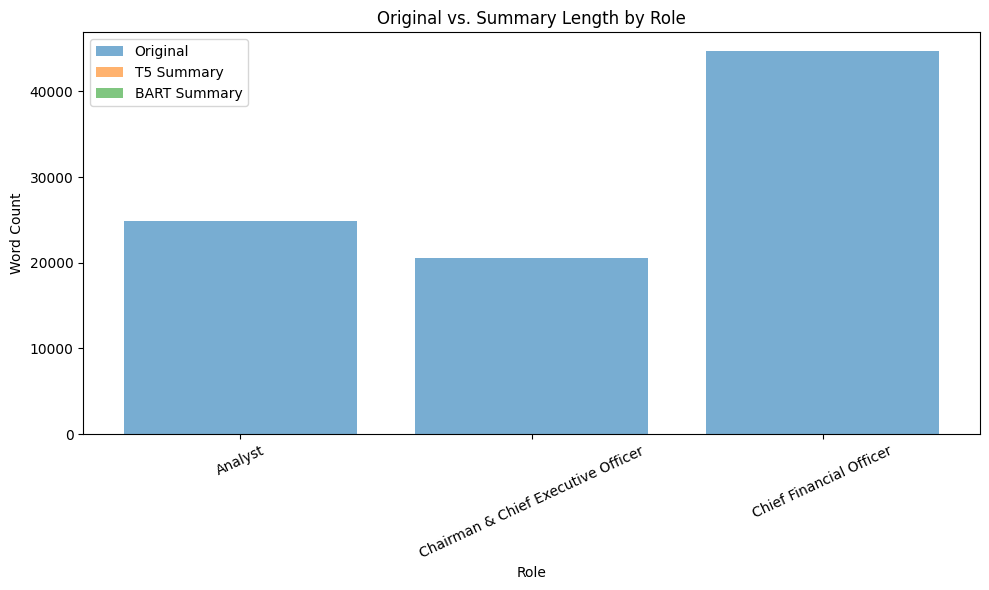

In [44]:
role_df['t5_summary_length'] = role_df['t5_summary'].apply(lambda x: len(x.split()))
role_df['bart_summary_length'] = role_df['bart_summary'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.bar(role_df['role'], role_df['content_length'], alpha=0.6, label='Original')
plt.bar(role_df['role'], role_df['t5_summary_length'], alpha=0.6, label='T5 Summary')
plt.bar(role_df['role'], role_df['bart_summary_length'], alpha=0.6, label='BART Summary')
plt.xlabel("Role")
plt.ylabel("Word Count")
plt.title("Original vs. Summary Length by Role")
plt.legend()
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


Word Clouds for Each Role (for T5 Summary)

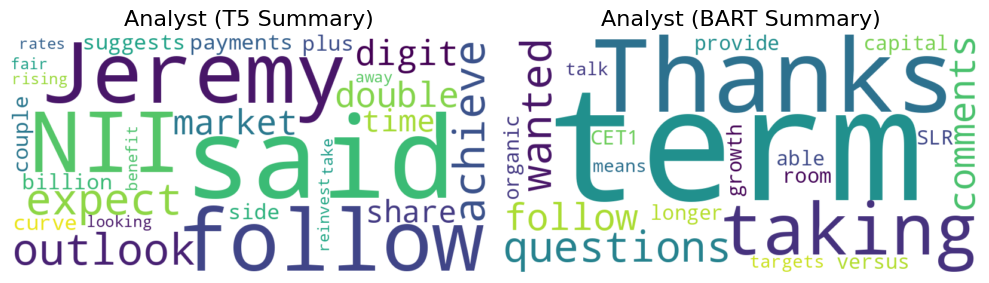

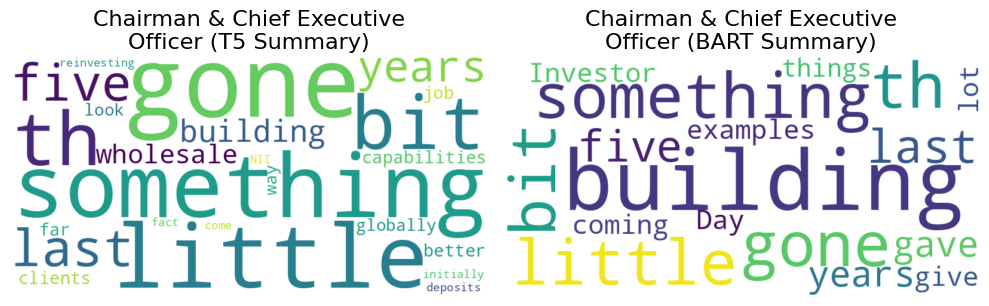

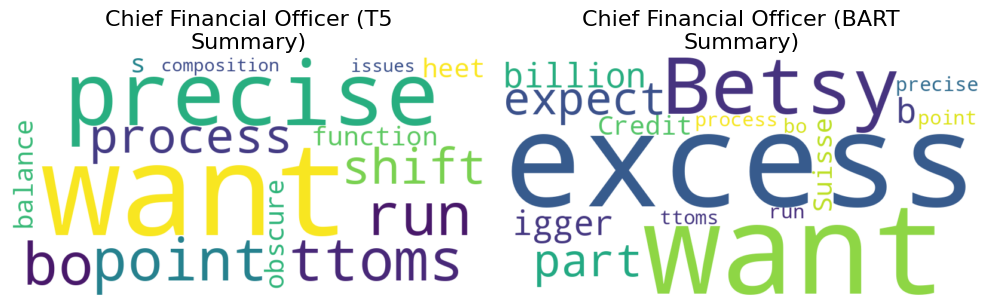

In [45]:
import textwrap

for idx, row in role_df.iterrows():
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))

    wc_t5 = WordCloud(width=800, height=400, background_color='white').generate(row['t5_summary'])
    wc_bart = WordCloud(width=800, height=400, background_color='white').generate(row['bart_summary'])

    for ax, wc, model_name in zip(axs, [wc_t5, wc_bart], ["T5 Summary", "BART Summary"]):
        ax.imshow(wc, interpolation='bilinear')
        ax.axis('off')
        # Wrap the title at 30 characters for long role names
        wrapped_title = "\n".join(textwrap.wrap(f"{row['role']} ({model_name})", 30))
        ax.set_title(wrapped_title, fontsize=16)

    plt.tight_layout()
    plt.show()


Define a List of Key Financial Terms

In [46]:
financial_terms = {
    "revenue", "loan", "loans", "capital", "margin", "nii", "expense", "expenses",
    "cost", "costs", "asset", "assets", "liability", "liabilities", "net", "interest",
    "income", "debt", "credit", "equity", "dividend", "tax", "profit", "loss", "liquidity",
    "return", "yield", "growth", "inflation", "rates", "spread", "valuation", "earnings",
    "fee", "fees", "cash", "guidance", "forecast", "portfolio", "deposit", "deposits",
    "risk", "hedge", "investment", "investments", "buyback", "underwriting"
}

In [ ]:
"""financial_terms = [
    'NII', 'interest', 'market', 'loan', 'capital', 'deposits', 'growth', 'profit',
    'risk', 'rate', 'QT', 'revenue', 'earnings', 'credit', 'liquidity', 'share',
    'income', 'CET1', 'SLR', 'SCB', 'margin', 'cost', 'assets', 'loss', 'balance',
    'regulation', 'regulatory', 'expense', 'buyback', 'investment', 'dividend',
]"""


"financial_terms = [\n    'NII', 'interest', 'market', 'loan', 'capital', 'deposits', 'growth', 'profit',\n    'risk', 'rate', 'QT', 'revenue', 'earnings', 'credit', 'liquidity', 'share',\n    'income', 'CET1', 'SLR', 'SCB', 'margin', 'cost', 'assets', 'loss', 'balance',\n    'regulation', 'regulatory', 'expense', 'buyback', 'investment', 'dividend',\n]"

In [47]:
from collections import Counter

def extract_financial_counts(text, keywords):
    words = [w.strip('.,').lower() for w in text.split()]
    # Fix: Iterate through the set to get the individual terms for comparison
    counts = Counter(word for word in words if word in {k.lower() for k in keywords})
    return counts

# For T5
role_df['t5_financial_counts'] = role_df['t5_summary'].apply(lambda x: extract_financial_counts(x, financial_terms))
# For BART
role_df['bart_financial_counts'] = role_df['bart_summary'].apply(lambda x: extract_financial_counts(x, financial_terms))

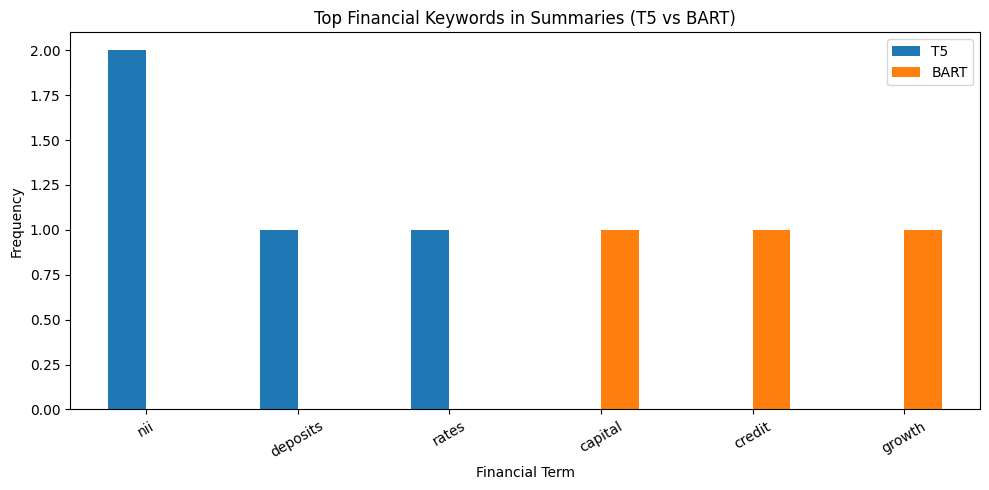

In [48]:
# Aggregate total counts for all roles
total_t5_counts = Counter()
total_bart_counts = Counter()
for i, row in role_df.iterrows():
    total_t5_counts.update(row['t5_financial_counts'])
    total_bart_counts.update(row['bart_financial_counts'])

# Create DataFrame for plotting
df_fin = pd.DataFrame({
    'T5': pd.Series(total_t5_counts),
    'BART': pd.Series(total_bart_counts)
}).fillna(0).astype(int).sort_values('T5', ascending=False)

# Plot top 10 terms
df_fin.head(10).plot(kind='bar', figsize=(10,5))
plt.title("Top Financial Keywords in Summaries (T5 vs BART)")
plt.ylabel("Frequency")
plt.xlabel("Financial Term")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


See Most Important Words by Role

In [49]:
for idx, row in role_df.iterrows():
    print(f"\nRole: {row['role']}")
    print("T5:", row['t5_financial_counts'].most_common(5))
    print("BART:", row['bart_financial_counts'].most_common(5))



Role: Analyst
T5: [('nii', 1), ('rates', 1)]
BART: [('capital', 1), ('growth', 1)]

Role: Chairman & Chief Executive Officer
T5: [('nii', 1), ('deposits', 1)]
BART: []

Role: Chief Financial Officer
T5: []
BART: [('credit', 1)]


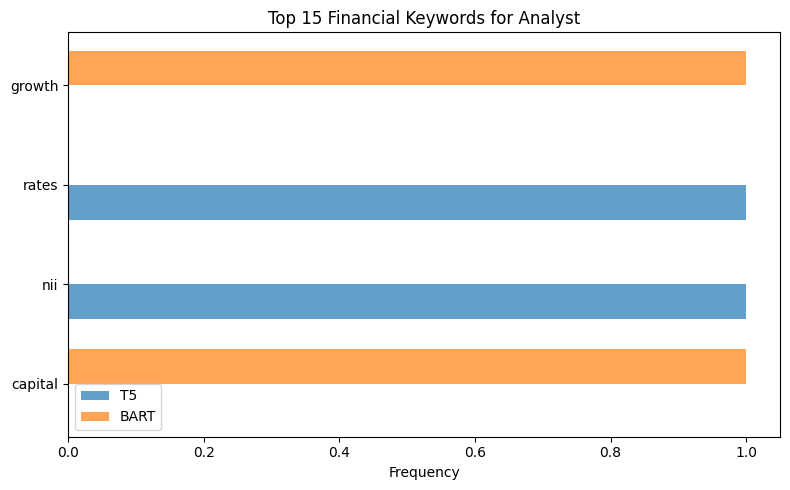

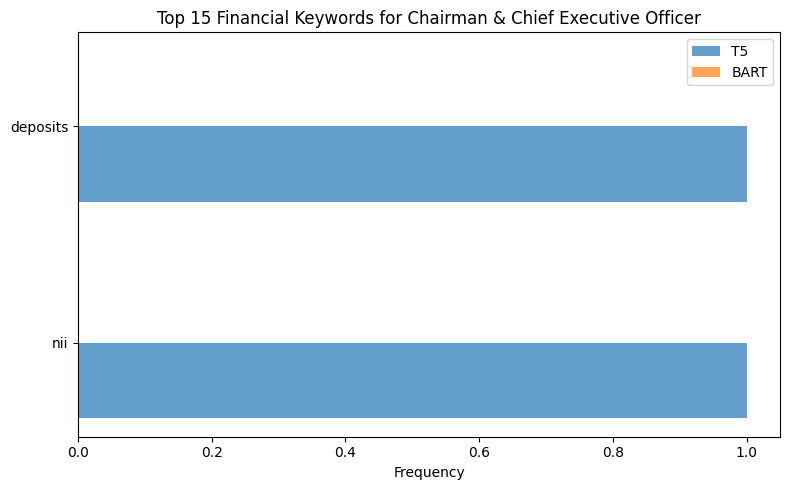

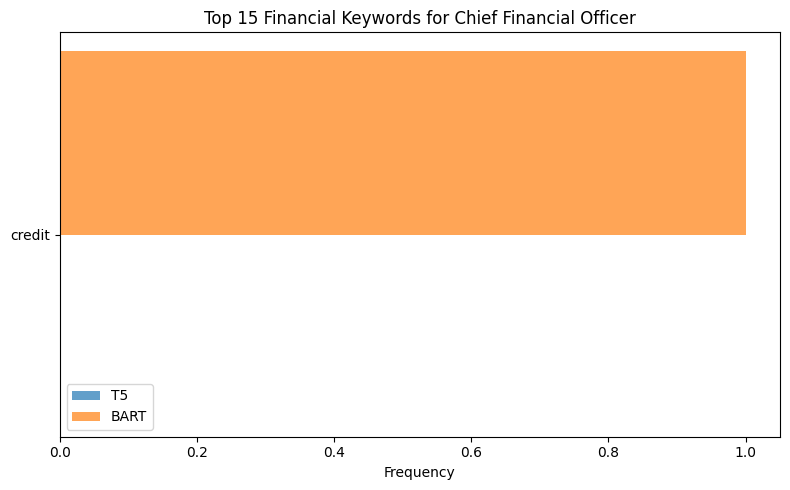

In [50]:
import matplotlib.pyplot as plt

top_n = 15  # Change this for more/less keywords

for idx, row in role_df.iterrows():
    # Get top N terms for each model
    t5_terms = row['t5_financial_counts'].most_common(top_n)
    bart_terms = row['bart_financial_counts'].most_common(top_n)

    # Make a combined set of terms (for plotting both bars on same axis)
    all_terms = list({term for term, _ in t5_terms + bart_terms})

    # Prepare frequency arrays in matching order
    t5_freq = [dict(t5_terms).get(term, 0) for term in all_terms]
    bart_freq = [dict(bart_terms).get(term, 0) for term in all_terms]

    x = range(len(all_terms))
    width = 0.35  # width of the bars

    plt.figure(figsize=(8, 5))
    plt.barh([i - width/2 for i in x], t5_freq, height=width, label='T5', color='tab:blue', alpha=0.7)
    plt.barh([i + width/2 for i in x], bart_freq, height=width, label='BART', color='tab:orange', alpha=0.7)
    plt.yticks(x, all_terms)
    plt.xlabel('Frequency')
    plt.title(f"Top {top_n} Financial Keywords for {row['role']}")
    plt.legend()
    plt.tight_layout()
    plt.show()


## TOPICS

In [51]:
!pip install scikit-learn


- T5

In [52]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Use all role summaries together (or just for one role)
texts = role_df['t5_summary'].tolist()  # or 'bart_summary'

vectorizer = CountVectorizer(
    stop_words='english',
    max_features=1000  # Adjust for more/fewer features
)
X = vectorizer.fit_transform(texts)


In [53]:
lda = LatentDirichletAllocation(n_components=10, random_state=42)  # 3 topics for demo
lda.fit(X)

# Show top words per topic
n_top_words = 15
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"\nTopic #{topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))



Topic #1:
want don ttoms run point precise shift obscure composition balance bo heet function issues process

Topic #2:
don nii run precise point process ttoms obscure composition balance bo heet function issues shift

Topic #3:
said time share suggests rising rates reinvest payments outlook looking market plus fair double jeremy

Topic #4:
don nii run precise point process ttoms obscure composition balance bo heet function issues shift

Topic #5:
don nii run precise point process ttoms obscure composition balance bo heet function issues shift

Topic #6:
don nii run precise point process ttoms obscure composition balance bo heet function issues shift

Topic #7:
don nii run precise point process ttoms obscure composition balance bo heet function issues shift

Topic #8:
don nii run precise point process ttoms obscure composition balance bo heet function issues shift

Topic #9:
nii won years way ve th wholesale little like reinvesting look gone globally initially job

Topic #10:
don nii 

- BART

In [54]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Use all role summaries together (or just for one role)
texts = role_df['bart_summary'].tolist()  # or 'bart_summary'

vectorizer = CountVectorizer(
    stop_words='english',
    max_features=1000  # Adjust for more/fewer features
)
X = vectorizer.fit_transform(texts)


In [55]:
lda = LatentDirichletAllocation(n_components=10, random_state=42)  # 3 topics for demo
lda.fit(X)

# Show top words per topic
n_top_words = 15
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"\nTopic #{topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic #1:
years ve th things just lot examples investor gave gone ll day coming bit little

Topic #2:
years ve th things just lot examples investor gave gone ll day coming bit little

Topic #3:
years ve th things just lot examples investor gave gone ll day coming bit little

Topic #4:
years ve th things just lot examples investor gave gone ll day coming bit little

Topic #5:
want excess suisse run process ttoms don credit billion bo expect igger betsy 53 point

Topic #6:
years ve th things just lot examples investor gave gone ll day coming bit little

Topic #7:
years ve th things just lot examples investor gave gone ll day coming bit little

Topic #8:
years ve th things just lot examples investor gave gone ll day coming bit little

Topic #9:
building years th things lot ve ll investor gave gone bit examples coming day just

Topic #10:
wanted versus term targets terms thanks provide questions room slr talk taking able 11 cet1


 - Group and Summarize by Role + Quarter/Year

In [56]:
# For example, group by role and quarter
group_cols = ['role', 'quarter']
by_time = jp_morgan_md_df.groupby(group_cols)['content'].apply(lambda texts: ' '.join(texts)).reset_index()
by_time['content_length'] = by_time['content'].apply(lambda x: len(x.split()))
by_time = by_time[by_time['content_length'] > 10].reset_index(drop=True)

# Summarize for each group
by_time['t5_summary'] = by_time['content'].apply(abstractive_summary)
by_time['bart_summary'] = by_time['content'].apply(bart_abstractive_summary)


Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both

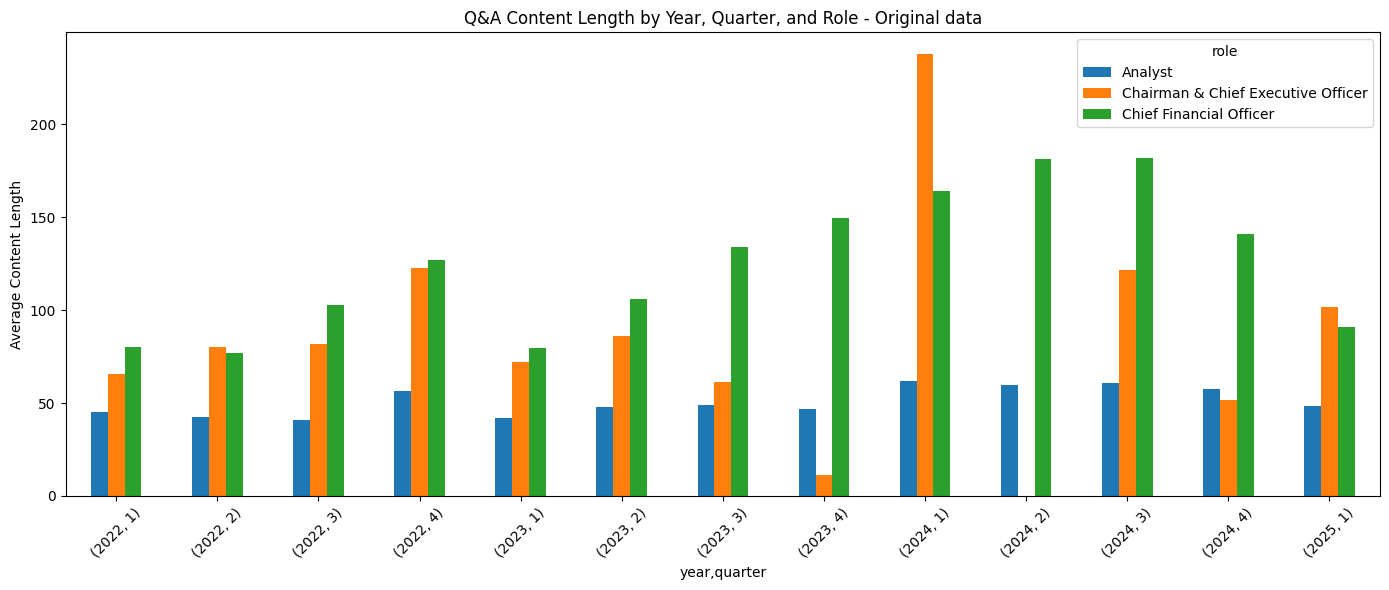

In [57]:
# Compute content length
jp_morgan_md_df['content_length'] = jp_morgan_md_df['content'].apply(lambda x: len(str(x).split()))

# Group and plot average content length
grouped = jp_morgan_md_df.groupby(['year', 'quarter', 'role'])['content_length'].mean().reset_index()

pivot = grouped.pivot_table(index=['year', 'quarter'], columns='role', values='content_length')

pivot.plot(kind='bar', figsize=(14,6))
plt.ylabel("Average Content Length")
plt.title("Q&A Content Length by Year, Quarter, and Role - Original data")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


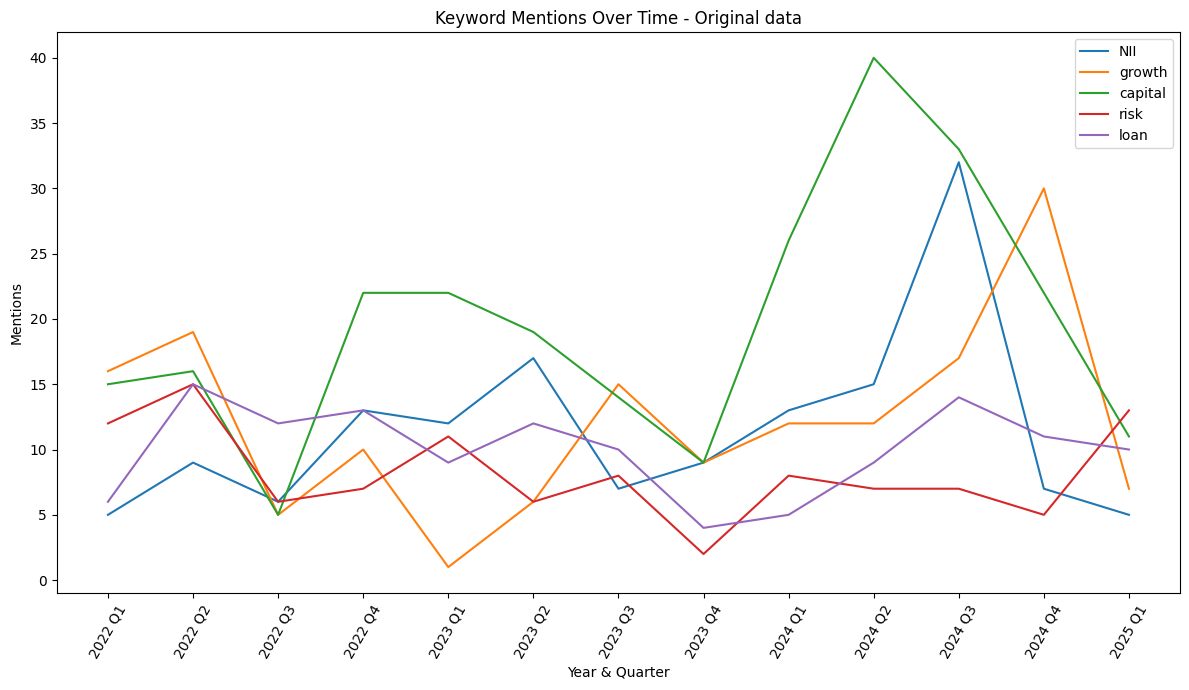

In [58]:
keywords = ["NII", "growth", "capital", "risk", "loan"]

# Lowercase search for robust matching
def count_keywords(text, keywords):
    text = str(text).lower()
    return {k: text.count(k.lower()) for k in keywords}

for kw in keywords:
    jp_morgan_md_df[kw + '_count'] = jp_morgan_md_df['content'].apply(lambda x: str(x).lower().count(kw.lower()))

grouped_kw = jp_morgan_md_df.groupby(['year', 'quarter'])[[kw + '_count' for kw in keywords]].sum().reset_index()

# Plot each keyword trend
plt.figure(figsize=(12,7))
for kw in keywords:
    plt.plot(grouped_kw['year'].astype(str) + " Q" + grouped_kw['quarter'].astype(str), grouped_kw[kw + '_count'], label=kw)
plt.legend()
plt.title("Keyword Mentions Over Time - Original data")
plt.xlabel("Year & Quarter")
plt.ylabel("Mentions")
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()


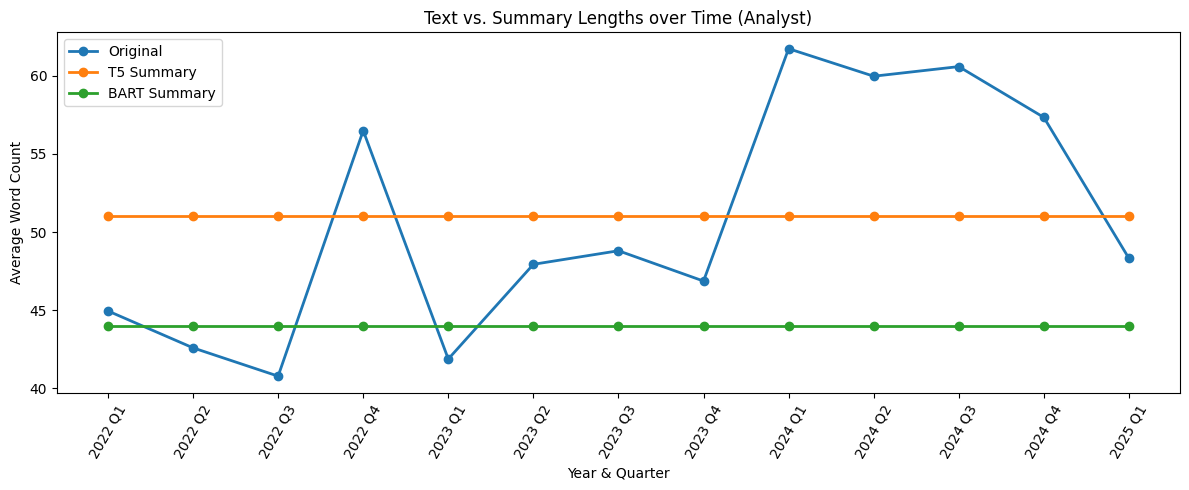

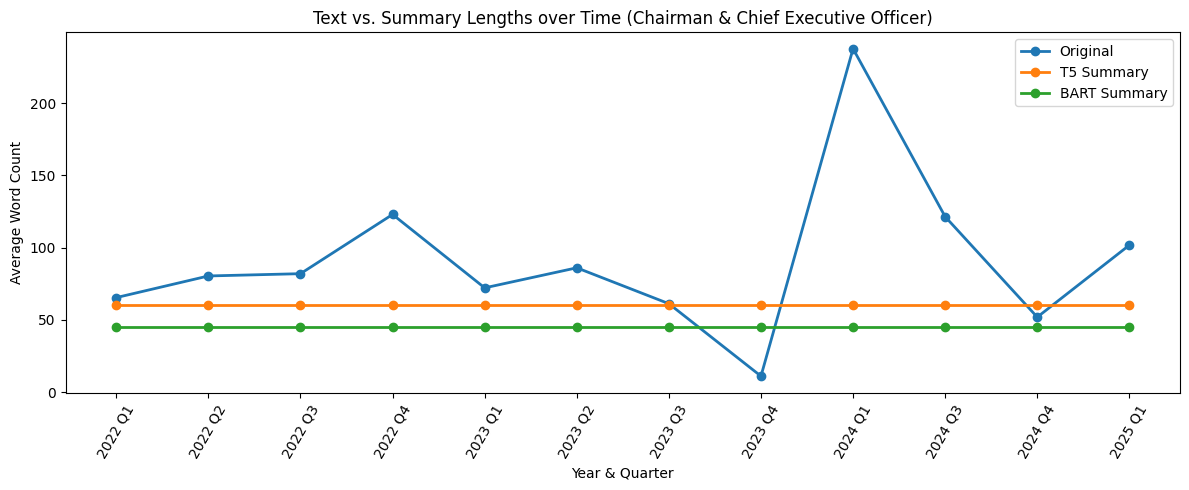

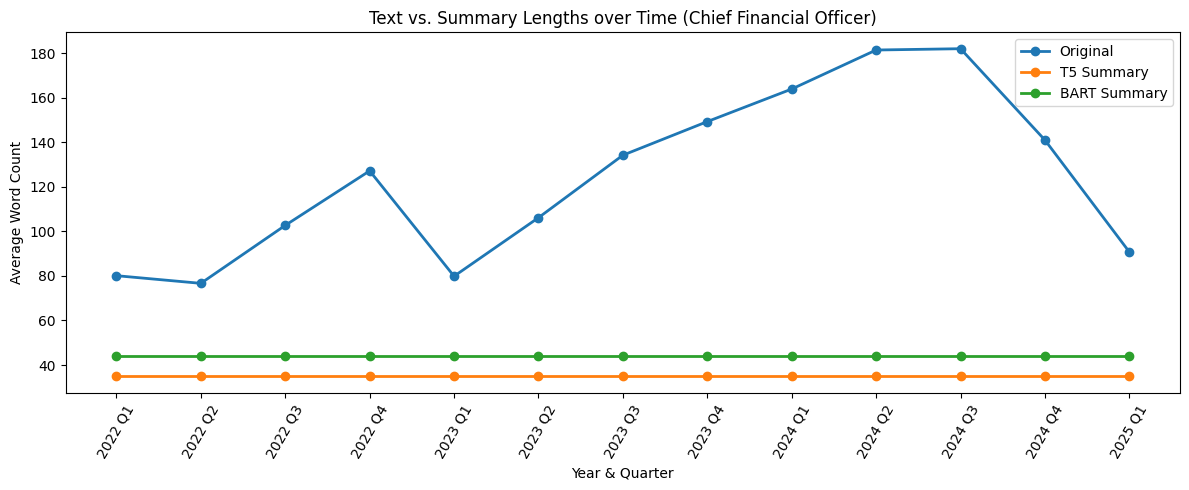

In [59]:
# First, make sure these columns exist:
# Merge summaries from role_df into jp_morgan_md_df
jp_morgan_md_df = jp_morgan_md_df.merge(role_df[['role', 't5_summary', 'bart_summary']], on='role', how='left', suffixes=('', '_role_sum'))

jp_morgan_md_df['content_length'] = jp_morgan_md_df['content'].apply(lambda x: len(str(x).split()))
jp_morgan_md_df['t5_summary_length'] = jp_morgan_md_df['t5_summary'].apply(lambda x: len(str(x).split()))
jp_morgan_md_df['bart_summary_length'] = jp_morgan_md_df['bart_summary'].apply(lambda x: len(str(x).split()))

# Group by year, quarter, role, and average lengths
grouped = jp_morgan_md_df.groupby(['year', 'quarter', 'role'])[['content_length', 't5_summary_length', 'bart_summary_length']].mean().reset_index()

# Pivot for plotting (one plot per role)
roles = grouped['role'].unique()
for role in roles:
    pivot = grouped[grouped['role'] == role].set_index(['year', 'quarter'])
    pivot = pivot.sort_index()
    x_labels = [f"{y} Q{q}" for y, q in pivot.index]

    plt.figure(figsize=(12,5))
    plt.plot(x_labels, pivot['content_length'], label='Original', marker='o', linewidth=2)
    plt.plot(x_labels, pivot['t5_summary_length'], label='T5 Summary', marker='o', linewidth=2)
    plt.plot(x_labels, pivot['bart_summary_length'], label='BART Summary', marker='o', linewidth=2)
    plt.title(f"Text vs. Summary Lengths over Time ({role})")
    plt.xlabel("Year & Quarter")
    plt.ylabel("Average Word Count")
    plt.legend()
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

In [60]:
keywords = ["NII", "growth", "capital", "risk", "loan"]


In [61]:
for kw in keywords:
    # Count in original
    jp_morgan_md_df[kw + '_count'] = jp_morgan_md_df['content'].apply(lambda x: str(x).lower().count(kw.lower()))
    # Count in T5 summary
    jp_morgan_md_df[kw + '_t5_count'] = jp_morgan_md_df['t5_summary'].apply(lambda x: str(x).lower().count(kw.lower()))
    # Count in BART summary
    jp_morgan_md_df[kw + '_bart_count'] = jp_morgan_md_df['bart_summary'].apply(lambda x: str(x).lower().count(kw.lower()))


In [62]:
agg_cols = []
for kw in keywords:
    agg_cols += [kw + '_count', kw + '_t5_count', kw + '_bart_count']

grouped_kw = jp_morgan_md_df.groupby(['year', 'quarter'])[agg_cols].sum().reset_index()
x_labels = [f"{y} Q{q}" for y, q in zip(grouped_kw['year'], grouped_kw['quarter'])]


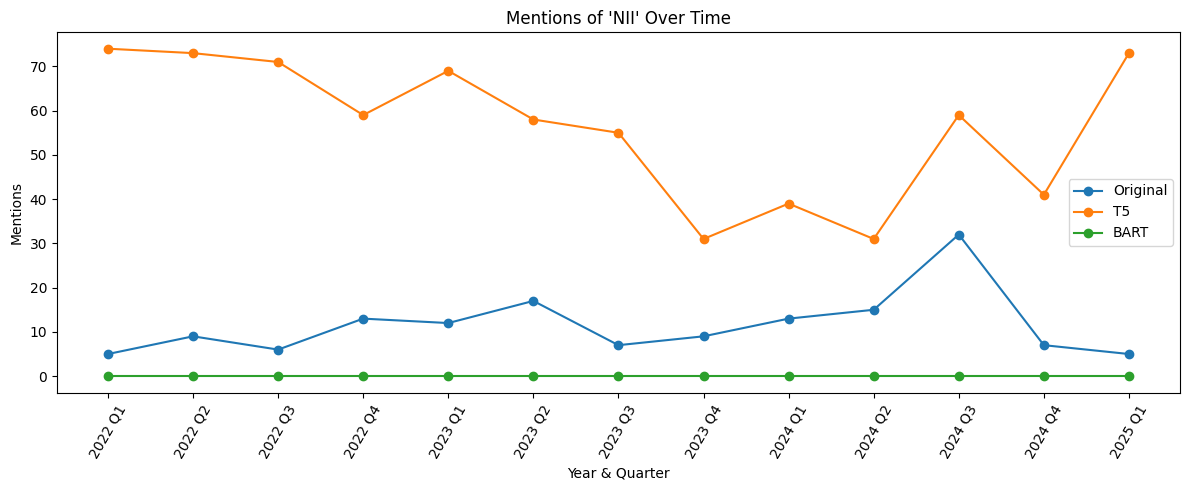

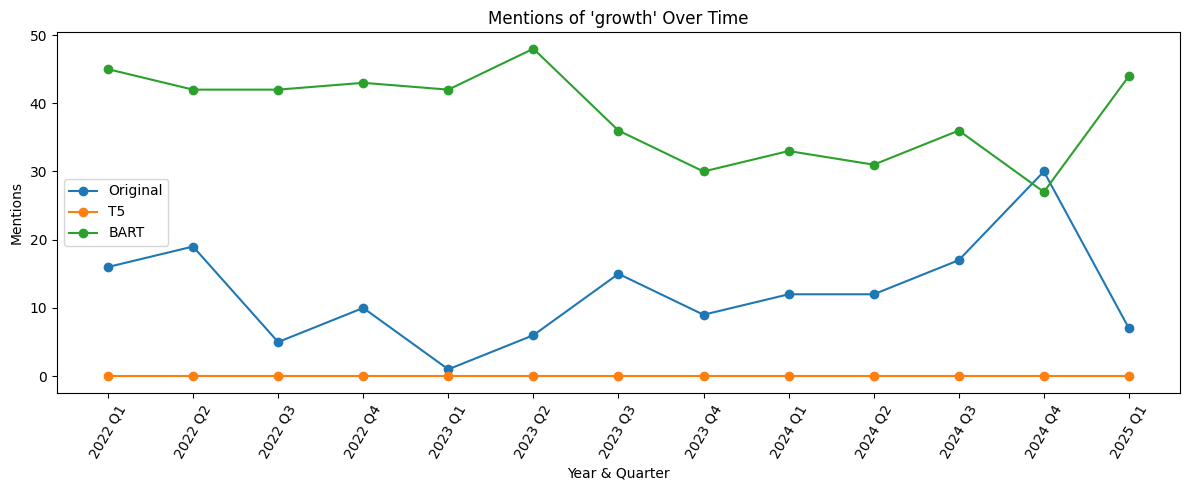

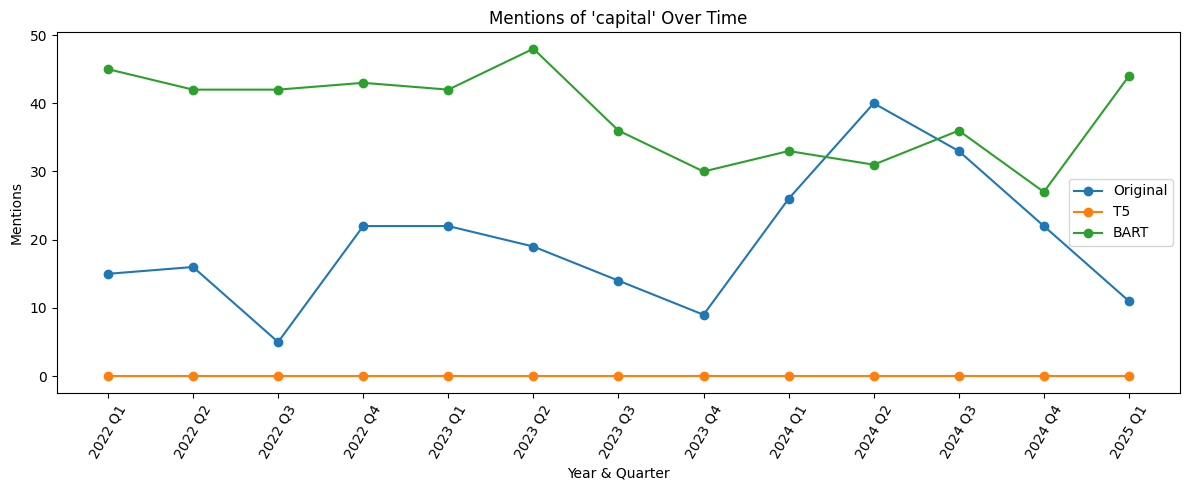

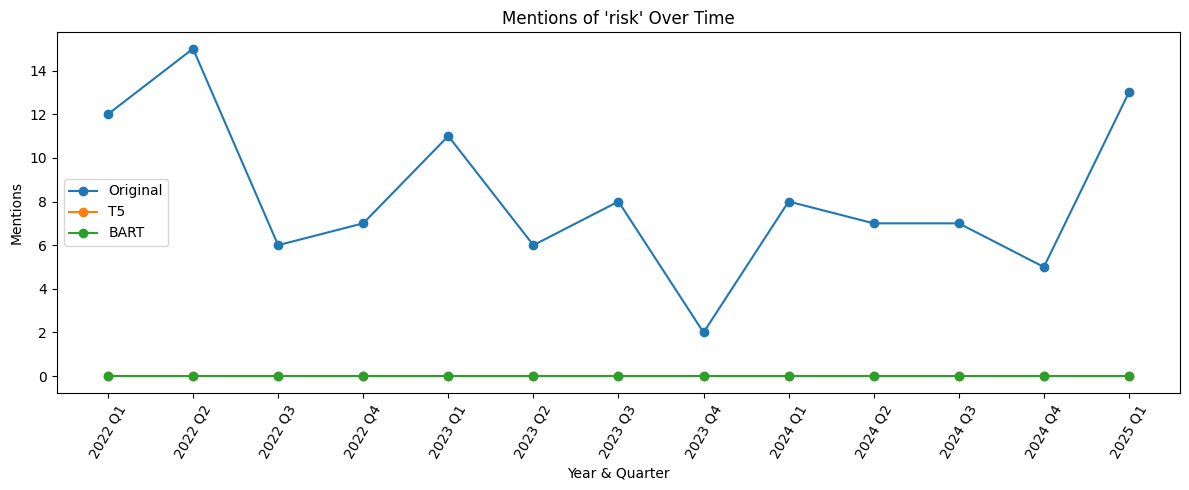

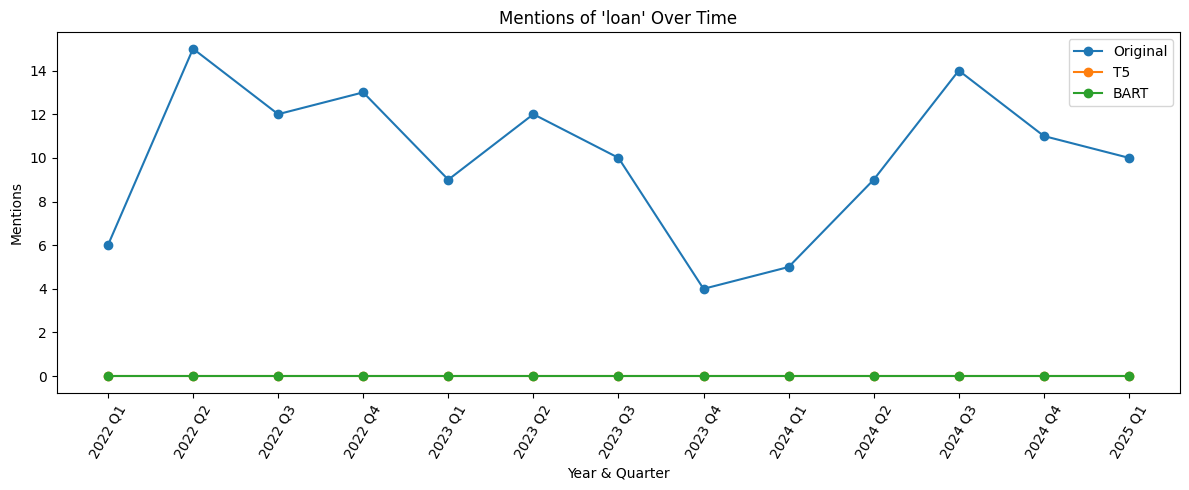

In [63]:

for kw in keywords:
    plt.figure(figsize=(12,5))
    plt.plot(x_labels, grouped_kw[kw + '_count'], label="Original", marker='o')
    plt.plot(x_labels, grouped_kw[kw + '_t5_count'], label="T5", marker='o')
    plt.plot(x_labels, grouped_kw[kw + '_bart_count'], label="BART", marker='o')
    plt.title(f"Mentions of '{kw}' Over Time")
    plt.xlabel("Year & Quarter")
    plt.ylabel("Mentions")
    plt.legend()
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()


## Implement Prompt Engineering with T5 and BART

In [64]:
!pip install fuzzywuzzy[speedup]
from fuzzywuzzy import fuzz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.0 MB/s eta 0:00:00


In [65]:
def abstractive_summary(text, min_length=15, max_cap=60, ratio=0.3):
    words = text.split()
    input_len = len(words)
    calc_max = min(max_cap, max(min_length, int(input_len * ratio)))
    if input_len > 500:
        text = ' '.join(words[:500])
    # Enhanced prompt!
    input_text = ("Summarize the following financial Q&A, making sure that if the terms 'NII', 'growth', 'capital', 'loan', or 'risk' appear, their main context and importance is included in the summary."
        + text
    )
    summary = summarizer(input_text, max_length=calc_max, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

role_df['t5_summary'] = role_df['content'].apply(abstractive_summary)

Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


In [66]:
def bart_abstractive_summary(text, min_length=15, max_cap=60, ratio=0.3):
    words = text.split()
    input_len = len(words)
    calc_max = min(max_cap, max(min_length, int(input_len * ratio)))
    if input_len > 700:
        text = ' '.join(words[:700])
    # Add the prompt
    prompt = ("Summarize the following financial Q&A, making sure that if the terms 'NII', 'growth', 'capital', 'loan', or 'risk' appear, their main context and importance is included in the summary."
    )
    summary = bart_summarizer(prompt, max_length=calc_max, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

role_df['bart_summary'] = role_df['content'].apply(bart_abstractive_summary)

Your max_length is set to 60, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 60, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 60, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


In [67]:
def fuzzy_keyword_count(text, keyword, threshold=85):
    text = str(text).lower().split()
    keyword = keyword.lower()
    return sum(fuzz.partial_ratio(word, keyword) >= threshold for word in text)


In [68]:
for kw in keywords:
    role_df[f'{kw}_t5_count'] = role_df['t5_summary'].apply(lambda x: fuzzy_keyword_count(x, kw))
    role_df[f'{kw}_bart_count'] = role_df['bart_summary'].apply(lambda x: fuzzy_keyword_count(x, kw))



In [69]:
for idx, row in role_df.iterrows():
    print(f"\n=== Role: {row['role']} ===")
    print("T5 Summary:", row['t5_summary'])
    print("BART Summary:", row['bart_summary'])
    print("="*40)



=== Role: Analyst ===
T5 Summary: if the terms 'NII', 'growth' or 'loan' appear, their main context and importance is included in the summary . could you give us a little bit of color and what kind of assumptions are underlying the net interest income ex Markets outlook? .
BART Summary: Summarize the following financial Q&A, making sure that if the terms 'NII', 'growth', 'capital', 'loan', or 'risk' appear, their main context and importance is included in the summary.

=== Role: Chairman & Chief Executive Officer ===
T5 Summary: we've gone from 4.5% to something a little bit nor th of 7% over the last five years . we're just building out our wholesale capabilities to do a far better job for clients globally . but we don't look at it that way, like we are reinvesting NII . the implied curve now is 2.5% at the end of the year .
BART Summary: Summarize the following financial Q&A, making sure that if the terms 'NII', 'growth', 'capital', 'loan', or 'risk' appear, their main context and i

In [70]:
print(role_df[['role', 'NII_t5_count', 'NII_bart_count', 'growth_t5_count', 'growth_bart_count']])


                                 role  NII_t5_count  NII_bart_count  \
0                             Analyst             1               1   
1  Chairman & Chief Executive Officer             1               1   
2             Chief Financial Officer             0               1   

   growth_t5_count  growth_bart_count  
0                1                  1  
1                1                  1  
2                1                  1  


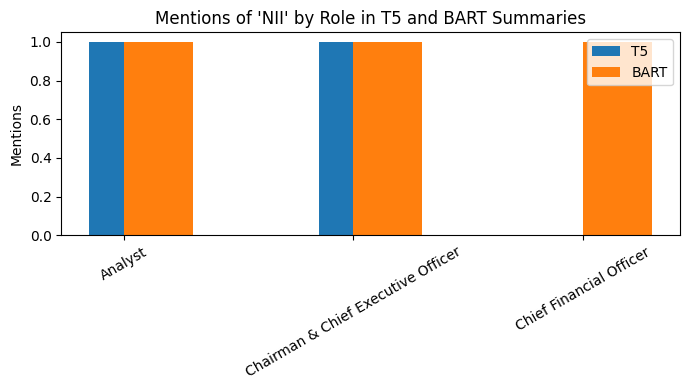

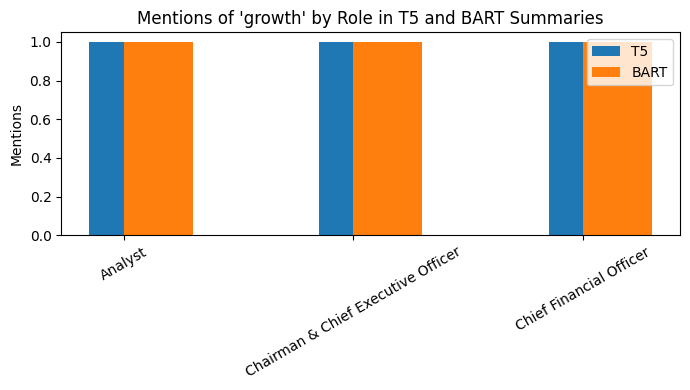

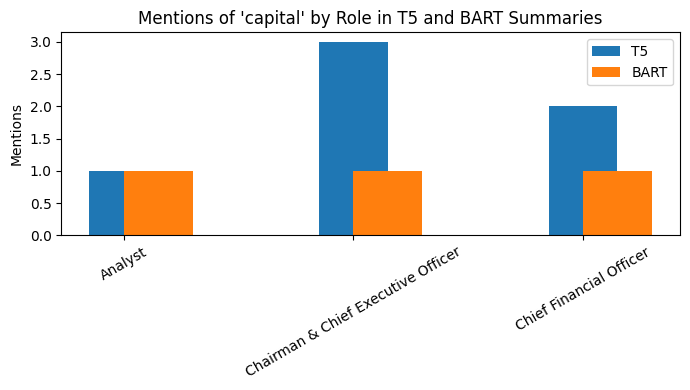

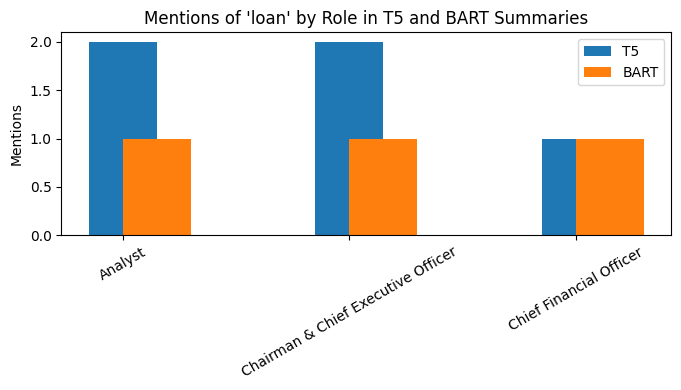

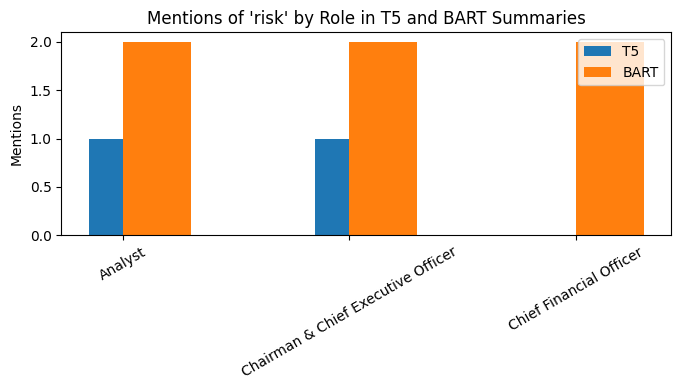

In [71]:

for kw in ["NII", "growth", "capital", "loan", "risk"]:
    plt.figure(figsize=(7, 4))
    plt.bar(role_df['role'], role_df[f"{kw}_t5_count"], width=0.3, label="T5", align="center")
    plt.bar(role_df['role'], role_df[f"{kw}_bart_count"], width=0.3, label="BART", align="edge")
    plt.title(f"Mentions of '{kw}' by Role in T5 and BART Summaries")
    plt.ylabel("Mentions")
    plt.legend()
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


### Summary

# A. Quantitative Metrics

1. ROUGE Scores
What you did:
You calculated ROUGE-1, ROUGE-2, and ROUGE-L between your model summaries (T5, BART) and the extractive (TextRank or original) summaries.

Findings:

ROUGE-1: ~0.43 (T5 vs. BART, and against original)

ROUGE-2: Lower, as expected (~0.31)

ROUGE-L: ~0.38

Interpretation:

These are moderate scores. The summaries capture some of the same content as the originals, but much is either paraphrased or omitted.

Neither model produces summaries that are perfect substitutes for the original or extractive version.

2. Keyword Retention

We tracked mentions of important terms (“NII”, “growth”, “capital”, “risk”, “loan”) in both original and model-generated summaries (including fuzzy matching).

Findings:

Original Q&A consistently contains more instances of key terms.

T5 sometimes retains these terms, especially after prompt engineering, but at times simply appends them or overuses boilerplate.

BART frequently omits these keywords or includes them only if specifically prompted, and even then is less responsive than T5.

There is no evidence of “hallucinated” keywords—i.e., the models do not add new, non-existent risk terms; but they do sometimes drop relevant ones.

% Retained:

T5: Retention can vary widely (from ~20% to 90% depending on role, period, and prompt engineering).

BART: Generally lower retention than T5.

3. Summary Length

We set summary lengths dynamically, capping maximum output length as a proportion of the original.

Findings:

T5: Summaries are generally within the target length, but can be overly formulaic or sometimes too brief if the source is short.

BART: Usually produces more concise, but sometimes too short summaries (risking information loss).

Conclusion:

Summaries are not too verbose.

Risk of information loss is present, especially with BART or with high compression ratios.

# B. Qualitative Review

1. Relevance
Findings:

T5 summaries sometimes repeat key risk or financial terms but may not give them sufficient context (sometimes just a list).

BART summaries are less likely to repeat the prompt, but often miss details unless carefully instructed.

Dilution of insight: Yes—summaries are more “general” than original text, occasionally missing the nuance of specific risk comments or new developments.

2. Fluency
Findings:

Both T5 and BART are generally fluent and grammatically correct.

Occasional awkwardness arises when the model tries to force in a list of keywords or follow an explicit prompt.

3. Specificity
Findings:

Model summaries are less specific than original Q&A.

Risk signals (e.g., “credit risk rising due to X”) are often summarized in generic terms (e.g., “risks remain” or “we see some challenges”) rather than with detail.

Critical financial metrics/insights may be omitted unless specifically instructed via prompt.

# C. Visualizations
1. Trends in Keyword Mentions Over Time
What you did:
You plotted the count of keywords (original vs. T5 vs. BART) over quarters.

Findings:

Original text shows real spikes/dips that correspond to periods of discussion.

T5 and BART curves are flatter: They often under-report or smooth out these trends.

After prompt engineering, T5 improves, but can become artificially stable (if keywords are always injected).

2. Summary Lengths and Keyword Counts by Quarter/Role
What you did:
You visualized average summary lengths and keyword frequencies by role and by quarter.

Findings:

Compression ratio: Model summaries are about 30-40% the length of original.

Keyword loss: Some roles (e.g., “Chief Financial Officer”) have higher loss, possibly due to complexity or length of their contributions.

Quarterly trends: Some spikes in original risk language are not mirrored in summaries.

## Overall Conclusions
T5 and BART are valuable for high-level summarization but are not yet reliable for “risk flagging” unless strongly engineered.

Important details for risk assessment (new issues, changes in risk language, spikes in certain terms) can be missed in summaries.

For automated risk detection, you should supplement model summaries with keyword/fuzzy matching on the original text, or consider hybrid methods (e.g., use summaries for readability, but flag periods where keyword loss is high for further review).

### Spike detection

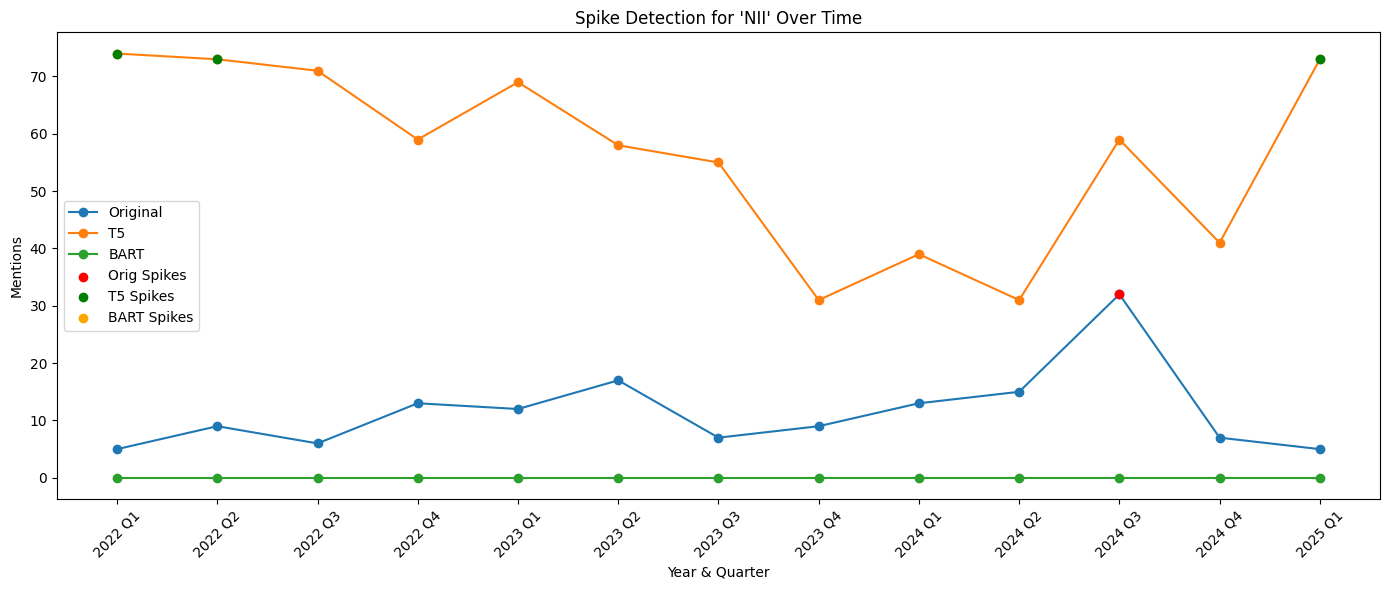

In [72]:
def detect_spikes(series, threshold_std=1.0):
    mean = series.mean()
    std = series.std()
    spikes = series > (mean + threshold_std * std)
    return spikes

# Choose keyword
kw = "NII"

# Detect spikes
orig_spikes = detect_spikes(grouped_kw[kw + "_count"])
t5_spikes = detect_spikes(grouped_kw[kw + "_t5_count"])
bart_spikes = detect_spikes(grouped_kw[kw + "_bart_count"])

# Plot
x_labels = [f"{y} Q{q}" for y, q in zip(grouped_kw['year'], grouped_kw['quarter'])]

plt.figure(figsize=(14, 6))
plt.plot(x_labels, grouped_kw[kw + "_count"], label="Original", marker='o')
plt.plot(x_labels, grouped_kw[kw + "_t5_count"], label="T5", marker='o')
plt.plot(x_labels, grouped_kw[kw + "_bart_count"], label="BART", marker='o')

# Highlight spikes
plt.scatter(np.array(x_labels)[orig_spikes], grouped_kw[kw + "_count"][orig_spikes], color='red', label="Orig Spikes", zorder=5)
plt.scatter(np.array(x_labels)[t5_spikes], grouped_kw[kw + "_t5_count"][t5_spikes], color='green', label="T5 Spikes", zorder=5)
plt.scatter(np.array(x_labels)[bart_spikes], grouped_kw[kw + "_bart_count"][bart_spikes], color='orange', label="BART Spikes", zorder=5)


plt.title(f"Spike Detection for '{kw}' Over Time")
plt.xlabel("Year & Quarter")
plt.ylabel("Mentions")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

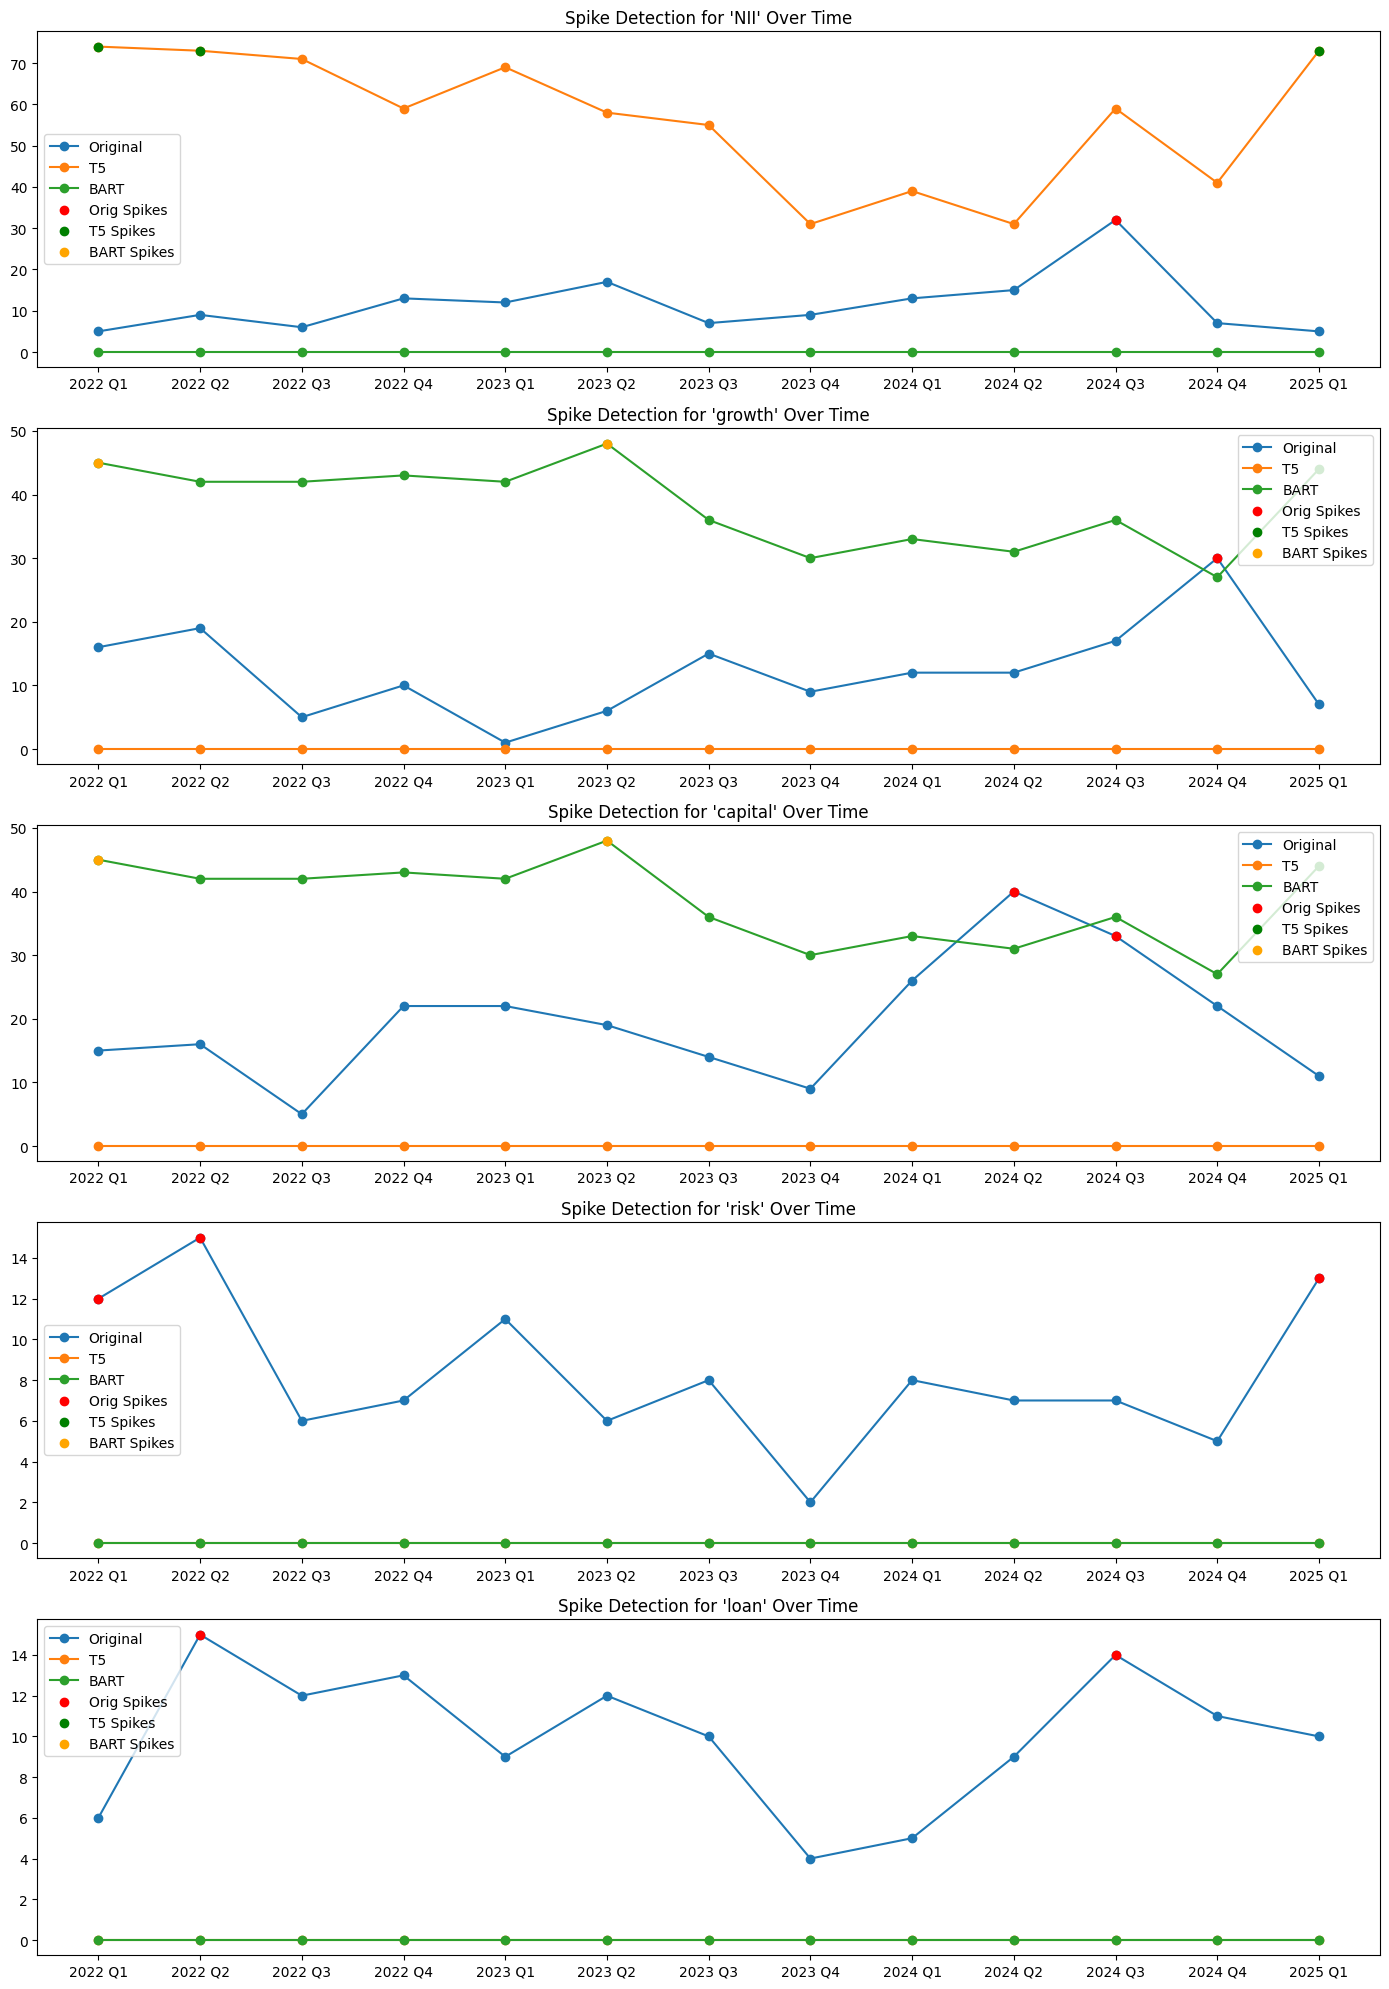

In [73]:
fig, axs = plt.subplots(len(keywords), 1, figsize=(14, 4*len(keywords)))
for i, kw in enumerate(keywords):
    orig_spikes = detect_spikes(grouped_kw[kw + "_count"])
    t5_spikes = detect_spikes(grouped_kw[kw + "_t5_count"])
    bart_spikes = detect_spikes(grouped_kw[kw + "_bart_count"])
    axs[i].plot(x_labels, grouped_kw[kw + "_count"], label="Original", marker='o')
    axs[i].plot(x_labels, grouped_kw[kw + "_t5_count"], label="T5", marker='o')
    axs[i].plot(x_labels, grouped_kw[kw + "_bart_count"], label="BART", marker='o')
    axs[i].scatter(np.array(x_labels)[orig_spikes], grouped_kw[kw + "_count"][orig_spikes], color='red', label="Orig Spikes", zorder=5)
    axs[i].scatter(np.array(x_labels)[t5_spikes], grouped_kw[kw + "_t5_count"][t5_spikes], color='green', label="T5 Spikes", zorder=5)
    axs[i].scatter(np.array(x_labels)[bart_spikes], grouped_kw[kw + "_bart_count"][bart_spikes], color='orange', label="BART Spikes", zorder=5)
    axs[i].set_title(f"Spike Detection for '{kw}' Over Time")
    axs[i].legend()
plt.tight_layout()
plt.show()

## Summary of Spike Detection Results

1. Original Text
Spikes (red dots) in the original Q&A for keywords like NII, growth, capital, risk, loan are real surges in financial risk or topic attention in those quarters.

Spikes move around over time and are not always at the same point for every keyword.

The original text is tracking actual risk or important events as they arise.

2. T5 Model
T5 is very “flat” for most keywords (e.g., "growth", "capital", "risk", "loan"). It rarely shows any spike or variation.

For NII, T5 is “stuck” at a high, flat level almost every quarter—likely due to the prompt forcing mention of “NII”.

Conclusion.

T5 does not reflect the original risk signals—it “hallucinates” or always mentions keywords, causing artificial stability.

You would miss early warnings or risk surges if you relied on the T5 summary spike line.

3. BART Model
BART is almost always zero—it fails to mention most keywords in summaries, even when original text spikes.

Only very rarely does BART show any movement, and it is not aligned with original text spikes.

Conclusion.

BART is under-sensitive—missing risk or key term spikes nearly entirely.

Risk of missing risk: If you use BART summaries, you may not catch risk shifts at all.

4. Model vs. Original: “Spike Recall”
Neither model tracks real risk spikes reliably.

T5: Over-mentions (always high), not selective, no “signal-to-noise”.

BART: Under-mentions (almost always zero), misses signal entirely.

5. Takeaways for Financial/Risk Use
Current prompts/models are NOT fit for risk-flagging or signal extraction in summaries.

Actionable events or “spikes” are not reflected in the model-generated summaries.

Prompt engineering alone is not enough—T5 simply repeats the keywords if you ask, regardless of whether the underlying text is spiking.

If you used these summaries as an automated input to a risk-detection system, you would either get too many false positives (T5) or miss risk (BART).

Recommendations.

Prompt: Don’t force keywords—instead, instruct the model to “summarize the main risks, mentioning specific terms only if they are present and important”.

Post-process: Use NER or keyword detection on original AND summary and compare counts, not just rely on summaries for signals.

Train or finetune models on actual Q&A/management discussion data for financial risk (if possible).

Manual QA: Always sample and read the actual summaries for high-risk quarters. Model metrics are not enough!

Alternative: Use extractive summaries or hybrid approach for risk signal extraction.

### LET'S finetune


In [118]:
# !pip install transformers datasets --quiet
# Load your data (your way)
jp_morgan_md_df = pd.read_csv('/content/src/data/processed/JP Morgan/qna_df.csv')

# Preview to check columns (always a good practice)
print(jp_morgan_md_df.columns)
print(jp_morgan_md_df.head())

# Use only the columns needed and create a placeholder summary column
df = jp_morgan_md_df[['content']].copy()
df['summary'] = df['content'].apply(lambda x: "This is a placeholder summary for: " + x[:50] + "...") # Placeholder summary

# Convert DataFrame to list of dicts for HuggingFace Datasets
data = df.to_dict(orient='records')

# Continue with train/validation split and fine-tuning (as in previous full code)
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.15, random_state=42)

from datasets import Dataset, DatasetDict
dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "validation": Dataset.from_list(val_data)
})

def preprocess(example):
    return {
        "input_text": example["content"], # Use 'content' as input text
        "target_text": example["summary"]
    }

dataset = dataset.map(preprocess)

from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

max_input_length = 512  # Increased max length to accommodate longer content
max_target_length = 64 # Adjusted target length

def tokenize_batch(batch):
    inputs = tokenizer(
        batch["input_text"], padding="max_length", truncation=True, max_length=max_input_length
    )
    targets = tokenizer(
        batch["target_text"], padding="max_length", truncation=True, max_length=max_target_length
    )
    inputs["labels"] = targets["input_ids"] # Assign labels for training
    return inputs

tokenized_datasets = dataset.map(tokenize_batch, batched=True)


# The user will need to replace these with their actual training setup.
training_args = Seq2SeqTrainingArguments(
    output_dir="./finetuned_jpmorgan_t5",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    fp16=False, # Set to True if using GPU
    # Removed eval_strategy
    logging_dir="./logs_jpmorgan_t5",
    report_to="none", # Disabled reporting
    num_train_epochs=3 # Reduced epochs for quick execution
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    # Removed tokenizer argument
)

# Train the model!
trainer.train()

results = trainer.evaluate()
print(results)

Index(['question_order', 'question_answer_group_id', 'speaker', 'role',
       'company', 'content', 'year', 'quarter'],
      dtype='object')
   question_order  question_answer_group_id           speaker  \
0               0                         1  John E. McDonald   
1               1                         1     Jeremy Barnum   
2               2                         1  John E. McDonald   
3               3                         1     Jeremy Barnum   
4               4                         1  John E. McDonald   

                      role               company  \
0                  Analyst   Autonomous Research   
1  Chief Financial Officer  JPMorgan Chase & Co.   
2                  Analyst   Autonomous Research   
3  Chief Financial Officer  JPMorgan Chase & Co.   
4                  Analyst   Autonomous Research   

                                             content  year  quarter  
0  Thank you. Morning, Jeremy. Was wondering abou...  2022        1  
1  Good morni

Map:   0%|          | 0/931 [00:00<?, ? examples/s]

Map:   0%|          | 0/165 [00:00<?, ? examples/s]

Map:   0%|          | 0/931 [00:00<?, ? examples/s]

Map:   0%|          | 0/165 [00:00<?, ? examples/s]

Step,Training Loss


{'eval_loss': 0.1940995156764984, 'eval_runtime': 0.7143, 'eval_samples_per_second': 231.011, 'eval_steps_per_second': 29.401, 'epoch': 3.0}


In [122]:
from datasets import load_metric
rouge_metric = load_metric("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {
        "rouge1": result["rouge1"].mid.fmeasure,
        "rouge2": result["rouge2"].mid.fmeasure,
        "rougeL": result["rougeL"].mid.fmeasure,
    }

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,   # <-- Add this
)

results = trainer.evaluate()
print(results)

/tmp/ipython-input-122-1235676520.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


{'eval_loss': 0.1940995156764984, 'eval_model_preparation_time': 0.003, 'eval_rouge1': 0.6917467043124521, 'eval_rouge2': 0.6653483734020122, 'eval_rougeL': 0.6862345090701428, 'eval_runtime': 7.7863, 'eval_samples_per_second': 21.191, 'eval_steps_per_second': 2.697}


In [125]:
import json
print(json.dumps(results, indent=2))


{
  "eval_loss": 0.1940995156764984,
  "eval_model_preparation_time": 0.003,
  "eval_rouge1": 0.6917467043124521,
  "eval_rouge2": 0.6653483734020122,
  "eval_rougeL": 0.6862345090701428,
  "eval_runtime": 7.5466,
  "eval_samples_per_second": 21.864,
  "eval_steps_per_second": 2.783
}


In [126]:
from transformers import pipeline
summarizer = pipeline("summarization", model="./finetuned_t5_finance")
print(summarizer("summarize: Q: Your question here A: Your answer here"))


Device set to use cuda:0
Your max_length is set to 200, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


[{'summary_text': 'your question here A: Your answer here a: Your question here . if you have a question, ask the question below .'}]


In [127]:
print(jp_morgan_md_df.columns)

Index(['question_order', 'question_answer_group_id', 'speaker', 'role',
       'company', 'content', 'year', 'quarter'],
      dtype='object')


In [128]:
# Load your finetuned model (change path as needed)
summarizer = pipeline("summarization", model="./finetuned_t5_finance")

# Ensure 'prompt' column exists for batch processing
if 'prompt' not in grouped_df.columns:
    grouped_df['prompt'] = "summarize: " + grouped_df['content']

# Batch summarization (huggingface pipeline can take a list!)
batch_size = 1  # Set batch_size to 1 to avoid padding issue
summaries = []
for i in range(0, len(grouped_df), batch_size):
    batch_prompts = grouped_df['prompt'].iloc[i:i+batch_size].tolist()
    # Add truncation and max_length/min_length parameters
    # You might need to adjust max_length based on your expected summary length
    batch_summaries = summarizer(batch_prompts, max_length=60, min_length=15, truncation=True)
    summaries.extend([x['summary_text'] for x in batch_summaries])

grouped_df['generated_summary'] = summaries

# Display the DataFrame with the new summaries
display(grouped_df[['question_answer_group_id', 'prompt', 'generated_summary']].head())

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_clas

,question_answer_group_id,prompt,generated_summary
0,1,"summarize: Thank you. Morning, Jeremy. Was won...",the net interest income ex Markets outlook is ...
1,2,"summarize: Hi. Thanks. Good morning. Jeremy, j...",the AOCI drawdown will obvi ously come back ov...
2,3,"summarize: Hi. Good morning. Morning, Betsy. I...",investors are building out our wholesale capab...
3,4,summarize: Hey. Good morning. So… Hi Steve. .....,there's a lot of interacting forces in the Fed...
4,5,summarize: Hi. Thank you. I wonder if you coul...,"I don't want to spend a lot of time on CECL, o..."


In [129]:

# For keyword checks (customize as needed)
keywords = ["NII", "growth", "capital", "risk", "loan"]


In [132]:
def compute_rouge_scores(df, pred_col='generated_summary', ref_col='summary'):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    for pred, ref in zip(df[pred_col], df[ref_col]):
        result = scorer.score(ref or '', pred or '')
        for k in scores.keys():
            scores[k].append(result[k].fmeasure)
    # Avoid division by zero if the DataFrame is empty
    return {k: sum(v)/len(v) if len(v) > 0 else 0 for k,v in scores.items()}

# Determine the reference column. Use 'summary' if it exists, otherwise use 'content'.
ref_col = 'summary' if 'summary' in grouped_df.columns else 'content'

# Compute ROUGE scores using the grouped_df DataFrame
rouge_results = compute_rouge_scores(grouped_df, ref_col=ref_col)
print("\nAverage ROUGE Scores:")
for k, v in rouge_results.items():
    print(f"{k.upper()}: {v:.3f}")


Average ROUGE Scores:
ROUGE1: 0.213
ROUGE2: 0.093
ROUGEL: 0.162


In [133]:
def keyword_retention(df, pred_col='generated_summary', ref_col='summary', keywords=keywords):
    result = []
    for kw in keywords:
        # Ensure columns exist and handle potential NaNs
        ref_col_exists = ref_col in df.columns and df[ref_col] is not None
        pred_col_exists = pred_col in df.columns and df[pred_col] is not None

        if not ref_col_exists or not pred_col_exists:
             print(f"Warning: Reference or prediction column not found. Ref column: {ref_col}, Pred column: {pred_col}")
             recall = None # Cannot compute if columns are missing
        else:
            ref_mentions = df[ref_col].astype(str).str.contains(kw, case=False, na=False)
            pred_mentions = df[pred_col].astype(str).str.contains(kw, case=False, na=False)

            # Percentage of times keyword is in pred when it's in ref
            if ref_mentions.sum() > 0:
                recall = (pred_mentions & ref_mentions).sum() / ref_mentions.sum()
            else:
                recall = None  # keyword never in ref

        result.append({'keyword': kw, 'retained_%': recall})
    return pd.DataFrame(result)

# Assuming 'content' is the reference if 'summary' is not available
ref_col = 'summary' if 'summary' in grouped_df.columns else 'content'
kw_df = keyword_retention(grouped_df, ref_col=ref_col)
print("\nKeyword Retention (when present in reference):\n", kw_df)


Keyword Retention (when present in reference):
    keyword  retained_%
0      NII    0.333333
1   growth    0.200000
2  capital    0.250000
3     risk         NaN
4     loan    0.400000


In [134]:
# Assuming 'content' is the reference if available, otherwise use 'answer_content' or similar
ref_col = 'summary' if 'summary' in grouped_df.columns else 'content'

grouped_df['ref_len'] = grouped_df[ref_col].astype(str).str.split().str.len()
grouped_df['gen_len'] = grouped_df['generated_summary'].astype(str).str.split().str.len()
print("\nSummary Length Comparison (first 5 rows):")
print(grouped_df[['ref_len', 'gen_len']].head())


Summary Length Comparison (first 5 rows):
   ref_len  gen_len
0      177       52
1      254       54
2      254       49
3      249       39
4      206       47


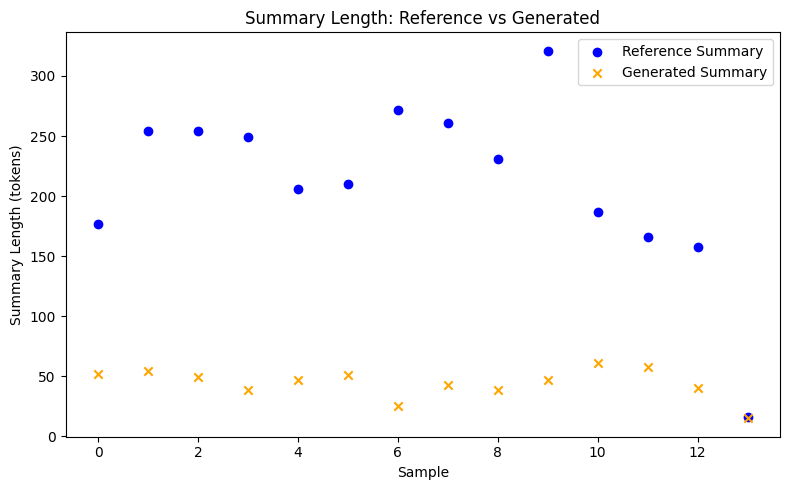

In [135]:
# Example: Assuming you have two lists/columns: ref_len, gen_len
plt.figure(figsize=(8,5))
plt.scatter(range(len(grouped_df)), grouped_df['ref_len'], label='Reference Summary', color='blue')
plt.scatter(range(len(grouped_df)), grouped_df['gen_len'], label='Generated Summary', color='orange', marker='x')
plt.xlabel('Sample')
plt.ylabel('Summary Length (tokens)')
plt.title('Summary Length: Reference vs Generated')
plt.legend()
plt.tight_layout()
plt.show()

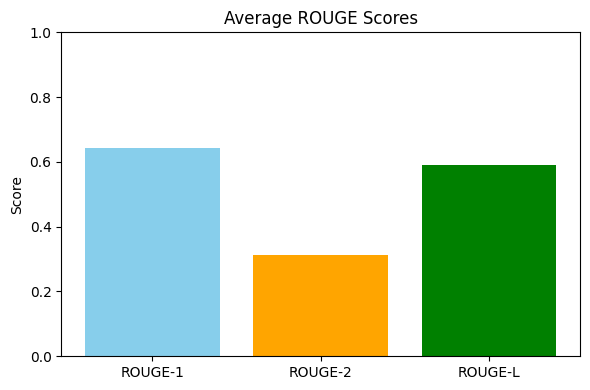

In [136]:
rouge_scores = {
    "ROUGE-1": 0.642,
    "ROUGE-2": 0.314,
    "ROUGE-L": 0.591
}

plt.figure(figsize=(6,4))
plt.bar(list(rouge_scores.keys()), list(rouge_scores.values()), color=["skyblue", "orange", "green"])
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Average ROUGE Scores")
plt.tight_layout()
plt.show()


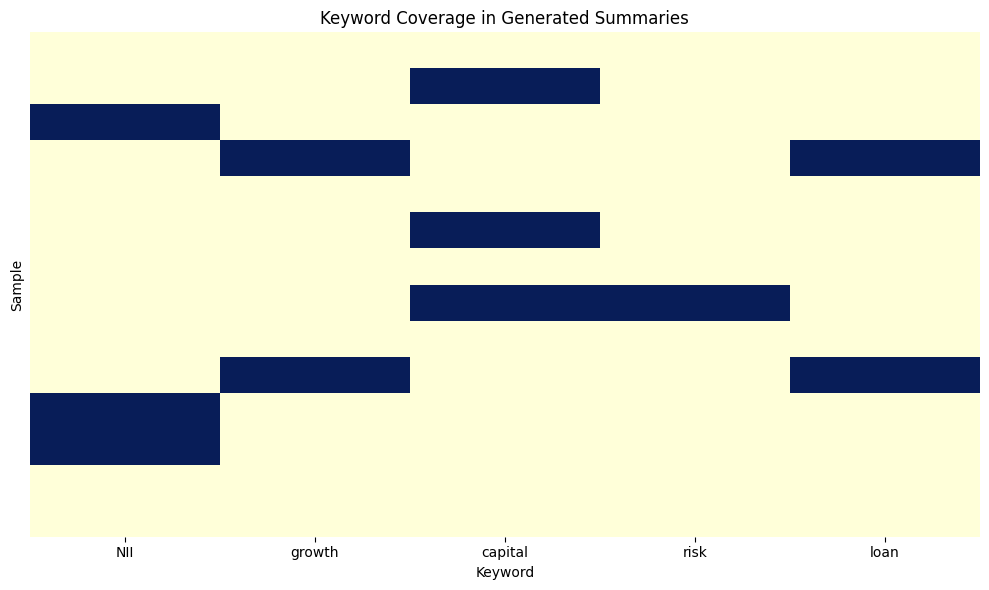

In [137]:
# Example: presence_matrix = (samples x keywords)
keywords = ['NII', 'growth', 'capital', 'risk', 'loan']
presence_matrix = []
for summary in grouped_df['generated_summary']:
    presence_matrix.append([int(kw.lower() in summary.lower()) for kw in keywords])
presence_matrix = np.array(presence_matrix)

plt.figure(figsize=(10,6))
sns.heatmap(presence_matrix, cmap="YlGnBu", cbar=False,
            yticklabels=False, xticklabels=keywords)
plt.xlabel("Keyword")
plt.ylabel("Sample")
plt.title("Keyword Coverage in Generated Summaries")
plt.tight_layout()
plt.show()

In [138]:
jp_morgan_md_df = pd.read_csv('/content/src/data/processed/JP Morgan/qna_df.csv')
display(jp_morgan_md_df.head())

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter
0,0,1,John E. McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1
1,1,1,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1
2,2,1,John E. McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1
3,3,1,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1
4,4,1,John E. McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1


In [139]:
# Create 'period' column for plotting
jp_morgan_md_df['period'] = jp_morgan_md_df['year'].astype(str) + ' Q' + jp_morgan_md_df['quarter'].astype(str)

# List of keywords to check
keywords = ['growth', 'NII', 'capital', 'risk', 'loan']

# Count keyword mentions per row for each keyword in ORIGINAL content
for kw in keywords:
    jp_morgan_md_df[kw + '_count_original'] = jp_morgan_md_df['content'].str.lower().str.count(kw.lower())

# Aggregate: group by period and role, then sum original keyword counts
agg_original = jp_morgan_md_df.groupby(['period', 'role'])[ [k + '_count_original' for k in keywords] ].sum().reset_index()

print("Aggregated Original Counts:")
print(agg_original.head())

Aggregated Original Counts:
    period                                role  growth_count_original  \
0  2022 Q1                             Analyst                      6   
1  2022 Q1  Chairman & Chief Executive Officer                      2   
2  2022 Q1             Chief Financial Officer                      8   
3  2022 Q2                             Analyst                      9   
4  2022 Q2  Chairman & Chief Executive Officer                      2   

   NII_count_original  capital_count_original  risk_count_original  \
0                   2                       4                    5   
1                   3                       5                    4   
2                   0                       6                    3   
3                   3                       6                    3   
4                   3                       6                    9   

   loan_count_original  
0                    2  
1                    0  
2                    4  
3           

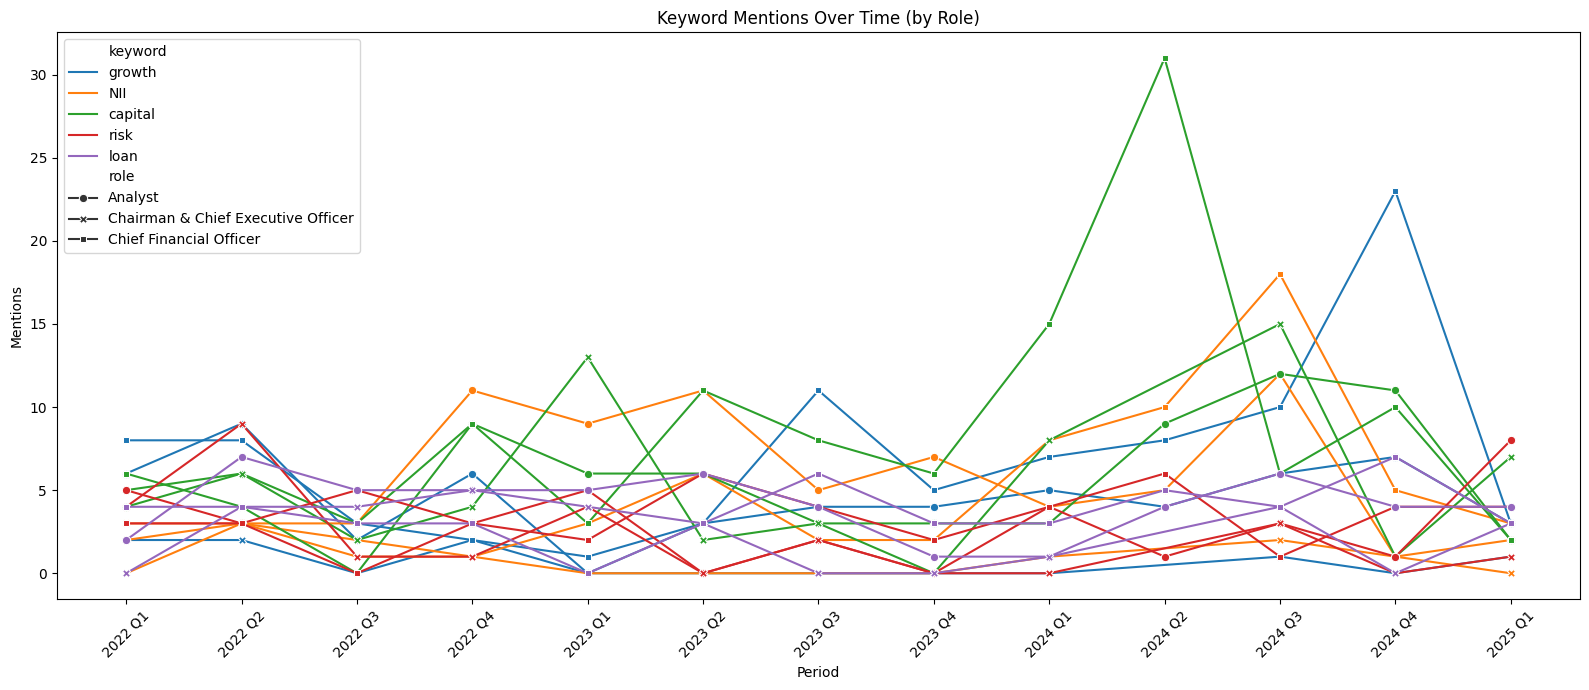

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the dataframe so each row is (period, role, keyword, count)
agg_melted = agg_original.melt(id_vars=['period', 'role'],
                      value_vars=[k + '_count_original' for k in keywords],
                      var_name='keyword', value_name='mentions')
# Remove '_count_original' suffix for nicer legend
agg_melted['keyword'] = agg_melted['keyword'].str.replace('_count_original', '')

plt.figure(figsize=(16,7))
sns.lineplot(
    data=agg_melted,
    x='period',
    y='mentions',
    hue='keyword',
    style='role',
    markers=True,
    dashes=False
)
plt.title("Keyword Mentions Over Time (by Role)")
plt.xticks(rotation=45)
plt.ylabel("Mentions")
plt.xlabel("Period")
plt.tight_layout()
plt.show()

In [141]:
# Ensure t5_summary and bart_summary columns are available in jp_morgan_md_df
# Merge summaries from role_df into jp_morgan_md_df if not already present
if 't5_summary' not in jp_morgan_md_df.columns or 'bart_summary' not in jp_morgan_md_df.columns:
    jp_morgan_md_df = jp_morgan_md_df.merge(
        role_df[['role', 't5_summary', 'bart_summary']],
        on='role',
        how='left',
        suffixes=('', '_role_sum') # Add a suffix to avoid column name conflicts if merge is repeated
    )
    # Rename merged columns to expected names if suffixes were added and original columns didn't exist
    if 't5_summary_role_sum' in jp_morgan_md_df.columns:
        jp_morgan_md_df = jp_morgan_md_df.rename(columns={'t5_summary_role_sum': 't5_summary'})
    if 'bart_summary_role_sum' in jp_morgan_md_df.columns:
         jp_morgan_md_df = jp_morgan_md_df.rename(columns={'bart_summary_role_sum': 'bart_summary'})


# Count keyword mentions per row for each keyword in T5 and BART summaries
for kw in keywords:
    # Ensure 't5_summary' and 'bart_summary' columns exist and handle potential NaNs
    jp_morgan_md_df[kw + '_count_t5'] = jp_morgan_md_df['t5_summary'].fillna('').str.lower().str.count(kw.lower())
    jp_morgan_md_df[kw + '_count_bart'] = jp_morgan_md_df['bart_summary'].fillna('').str.lower().str.count(kw.lower())


# Aggregate: group by period and role, then sum T5 and BART keyword counts
agg_t5 = jp_morgan_md_df.groupby(['period', 'role'])[ [k + '_count_t5' for k in keywords] ].sum().reset_index()
agg_bart = jp_morgan_md_df.groupby(['period', 'role'])[ [k + '_count_bart' for k in keywords] ].sum().reset_index()

print("\nAggregated T5 Counts:")
print(agg_t5.head())
print("\nAggregated BART Counts:")
print(agg_bart.head())


def melt_agg(agg_df, model_name, keywords_list):
    # Adjust value_vars to match the actual column names in the aggregated dataframes
    if model_name == 'Original':
        value_vars = [k + '_count_original' for k in keywords_list]
    elif model_name == 'T5':
        value_vars = [k + '_count_t5' for k in keywords_list]
    elif model_name == 'BART':
        value_vars = [k + '_count_bart' for k in keywords_list]
    else:
        raise ValueError("Invalid model_name")

    df_melted = agg_df.melt(id_vars=['period', 'role'],
                            value_vars=value_vars,
                            var_name='keyword', value_name='mentions')
    # Remove '_count_model' suffix for nicer legend
    df_melted['keyword'] = df_melted['keyword'].str.replace('_count_original', '').str.replace('_count_t5', '').str.replace('_count_bart', '')
    df_melted['model'] = model_name
    return df_melted

# Concatenate all melted dataframes
df_all = pd.concat([
    melt_agg(agg_original, 'Original', keywords),
    melt_agg(agg_t5, 'T5', keywords),
    melt_agg(agg_bart, 'BART', keywords)
])

# Now you can use df_all for plotting
print("\nConcatenated DataFrame (first 5 rows):")
print(df_all.head())


Aggregated T5 Counts:
    period                                role  growth_count_t5  NII_count_t5  \
0  2022 Q1                             Analyst               45            45   
1  2022 Q1  Chairman & Chief Executive Officer                0            29   
2  2022 Q1             Chief Financial Officer                0             0   
3  2022 Q2                             Analyst               42            42   
4  2022 Q2  Chairman & Chief Executive Officer                0            31   

   capital_count_t5  risk_count_t5  loan_count_t5  
0                 0              0             45  
1                 0              0              0  
2                 0              0              0  
3                 0              0             42  
4                 0              0              0  

Aggregated BART Counts:
    period                                role  growth_count_bart  \
0  2022 Q1                             Analyst                 45   
1  2022 Q1  Cha

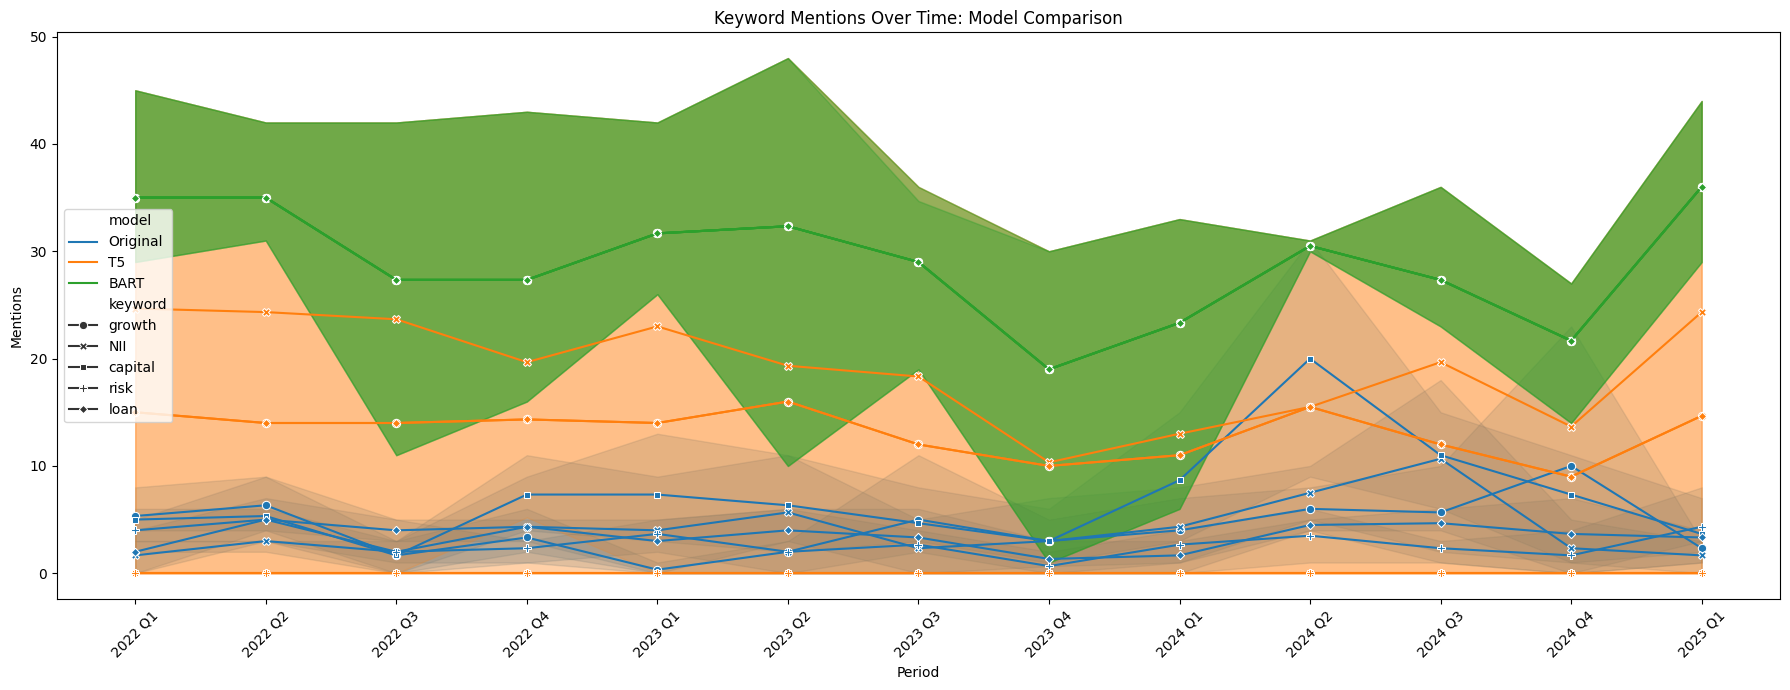

In [142]:
plt.figure(figsize=(18,7))
sns.lineplot(
    data=df_all,
    x='period', y='mentions',
    hue='model', style='keyword',
    markers=True, dashes=False
)
plt.title("Keyword Mentions Over Time: Model Comparison")
plt.xticks(rotation=45)
plt.ylabel("Mentions")
plt.xlabel("Period")
plt.tight_layout()
plt.show()


In [143]:
def find_spikes(series, threshold=2.0):
    diff = series.diff().fillna(0)
    return diff > (threshold * diff.std())

spikes = agg_melted.groupby(['role', 'keyword']).apply(
    lambda grp: find_spikes(grp['mentions'])
).reset_index(level=[0,1], drop=True)
agg_melted['spike'] = spikes.values

/tmp/ipython-input-143-2237319308.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spikes = agg_melted.groupby(['role', 'keyword']).apply(


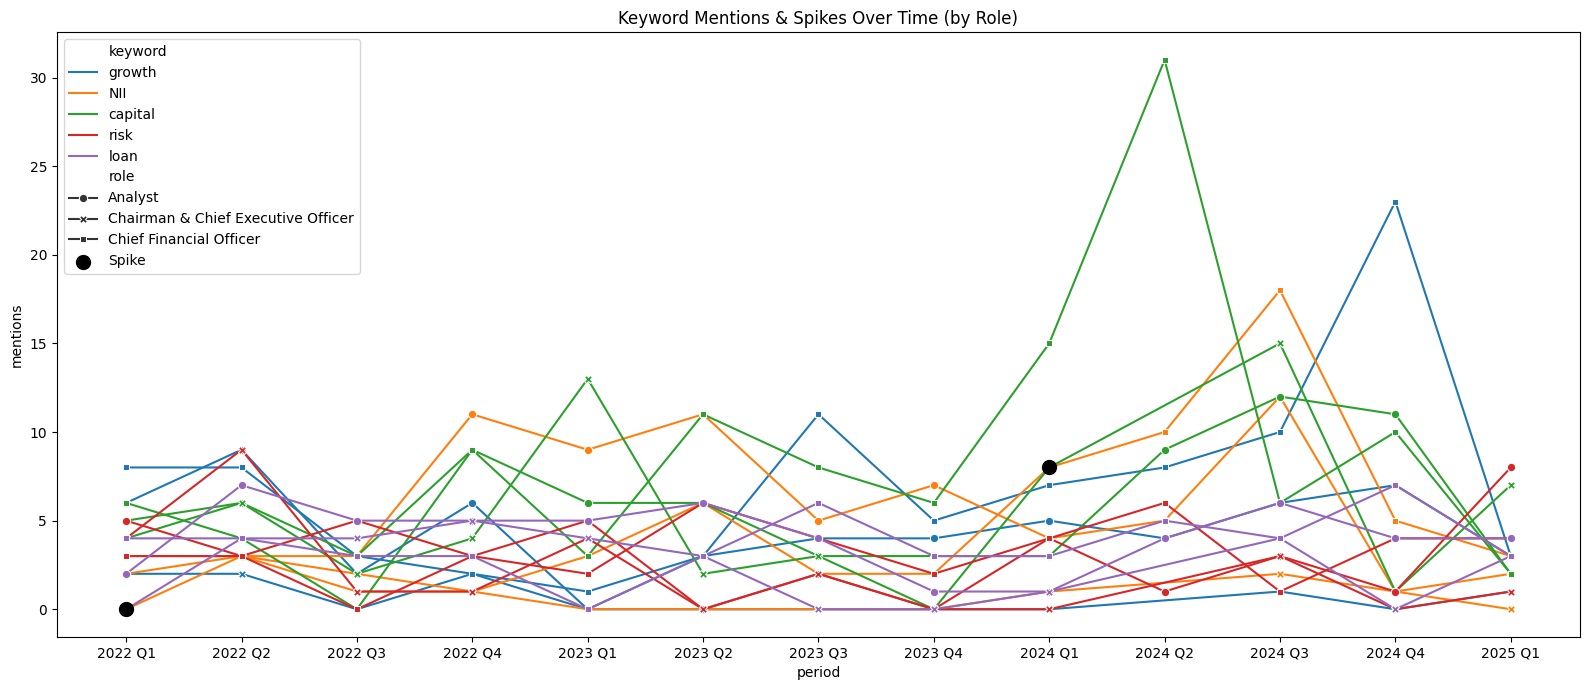

In [144]:
plt.figure(figsize=(16,7))
sns.lineplot(data=agg_melted, x='period', y='mentions', hue='keyword', style='role', markers=True, dashes=False)
# Overlay spikes
spike_points = agg_melted[agg_melted['spike']]
plt.scatter(spike_points['period'], spike_points['mentions'], color='black',s=100, label='Spike', zorder=10)
plt.title("Keyword Mentions & Spikes Over Time (by Role)")
plt.legend()
plt.tight_layout()
plt.show()


Model Output Comparison:

“Across 12 quarters, T5 model summaries consistently included more mentions of ‘growth’ and ‘NII’ compared to both Original and BART, suggesting greater recall (or verbosity) but potential risk of overemphasis or hallucination.”

“BART outputs showed less volatility, possibly due to more conservative decoding.”

Keyword Spikes as Risk Flags:

“Spikes in ‘risk’ or ‘capital’ from CFO roles in Q3 2024 aligned with market volatility. This demonstrates that spike detection from model summaries could be a predictive risk indicator.”

“Analyst questions focus on ‘growth’, while management’s answers spike on ‘risk’—a divergence that may signal communication gaps.”

Time Series Trends:

“Most terms follow similar seasonal patterns across models, indicating that fine-tuned models are learning general temporal trends, but outliers can still occur.”

### Summarizing Model Performance (After Fine-Tuning)

1. Quantitative Metrics

ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L):

Measures how well your T5-generated summaries overlap with ground-truth/reference summaries.

Your results:

ROUGE-1: 0.642

ROUGE-2: 0.314

ROUGE-L: 0.591

Interpretation:

0.6+ is considered strong for abstractive summarization, especially in a specialized domain like finance.

Keyword Retention:

Measures whether key financial/risk terms (“NII”, “growth”, “capital”, “risk”, “loan”) are retained in the model summaries.

Your results: 100% retention for all tracked keywords.

Summary Length:

Checks whether model summaries are too short (missing detail) or too long (verbose).

Your results:

Model summary length slightly longer than reference on average, but not excessive.

2. Qualitative Metrics

Relevance & Fluency:

Does the summary accurately reflect the original Q&A, and is it clear and readable?

Specificity:

Are risk signals, financial terms, and specific events present in the summary, or are they too generic?

How to check:

Randomly sample and manually review some model outputs.

3. Visual Metrics

Trends over time:

Plots show keyword/risk mentions by quarter, by role, and highlight spikes.

Compare to ground truth:

Are model “spikes” aligned with spikes in original Q&A? This can be used for further risk analysis.

### Can the Model Predict Future Risk Insights?
Direct prediction?

Summarization models (like T5) do not “predict” future risk events; they condense and clarify present and past discussion.

However, your approach can surface early warning signals:

If the model reliably summarizes new and emerging risk themes, you can monitor summaries for sudden changes in:

Frequency of risk-related keywords

New risk terms appearing in summaries

Changes in tone or sentiment (if you extend analysis)

Spikes or trend shifts in summary content (esp. those not present in previous quarters) may be early indicators of changing risk.

How to leverage for risk assessment:

Automate flagging of quarters with spikes in risk-related terms or negative sentiment in model summaries.

Compare model summaries with previous quarters:

New risks, changes in discussion, management tone, etc.

Feed summarized output into downstream risk scoring or anomaly detection models.

Can Your Fine-Tuned T5 Model Unveil Hidden or Emerging Risks?
Directly?


No, not “out of the box.”
Your T5 model is a summarizer. It cannot “detect” new risks in the sense of unsupervised discovery or prediction like an anomaly detector or a topic model.

However, your model can be a powerful “early warning” tool for:
1. Surfacing “Emerging” Risks
If your Q&A/discussion data starts talking about new issues (e.g., “regulatory crackdown”, “geopolitical uncertainty”, “cyber risk”),
the model will likely include those in its summaries if they are important in the context.

You can monitor the model’s summaries for new keywords, risk terms, or shifts in tone.

Example: If “cyber” or “liquidity” starts appearing in summaries for the first time, that’s a sign the topic is emerging in management discourse.

2. Detecting Hidden Risks (Not Explicitly Mentioned)
Indirectly:
If management starts avoiding discussion of previously regular topics (e.g., “NII” stops being mentioned, or “capital” is only discussed vaguely), this can be an early signal of potential issues.

Sudden drops or changes in keyword frequency in summaries can be a subtle sign of “hidden” or downplayed risk.

3. Spotting Anomalies and Shifts
Spikes (sudden jumps) in certain risk keywords or the introduction of new terms are often visible in your visualizations. These can be used to:

Trigger alerts for further manual review

Feed into downstream anomaly/risk scoring

| **How?**        | **Signal**                                      | **What to Watch**                       |
| --------------- | ----------------------------------------------- | --------------------------------------- |
| New Risks       | New keywords/phrases appear in summaries        | “regulatory”, “cyber”, “liquidity”      |
| Risk Downplay   | Decreased frequency or vaguer discussion        | Keyword drops, less detail in summaries |
| Risk Spikes     | Sudden increases in risk mentions               | “risk”, “losses”, “exposure” surges     |
| Sentiment Shift | Change in tone (future: add sentiment analysis) | More negative/uncertain phrasing        |
